# Имопртирование библиотек

In [230]:
!conda list > requirements.txt

In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
import networkx as nx
from feature_engine import encoding as ce

from sklearn.metrics import f1_score, fbeta_score, roc_auc_score, roc_curve, auc, confusion_matrix, precision_score, accuracy_score, recall_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_breast_cancer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

import torch

from sdv.single_table import CTGANSynthesizer
from sdv.datasets.demo import get_available_demos, download_demo
from sdv.evaluation.single_table import run_diagnostic
from sdv.metadata import SingleTableMetadata

# import sys
# sys.path.append('./BAMT')

# import bamt.preprocessors as pp
# import bamt.networks as nets

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, BicScore
from pgmpy.estimators import K2Score, BDsScore
from pgmpy.sampling import BayesianModelSampling

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

/Users/danilzgonnik/opt/anaconda3/envs/ctgan_bn_comparison/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # Load the Drive helper and mount
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
CTGAN_COLOR = '#FF00FF'
BAMT_COLOR = '#1E90FF'
REAL_COLOR = '#006400'

In [4]:
def lgbm_predict(xx_train, yy_train, xx_test, yy_test, categorical_features, reg=False):
    for col in categorical_features:
        xx_train[col] = xx_train[col].astype('category')
        xx_test[col] = xx_test[col].astype('category')
    if not reg:
        model = lgb.LGBMClassifier(random_state=42, categorical_feature=categorical_features)
        model.fit(xx_train, yy_train)
        y_pred_test = model.predict_proba(xx_test)[:, 1]
    else:
        model = lgb.LGBMRegressor(random_state=42, categorical_feature=categorical_features)
        model.fit(xx_train, yy_train)
        y_pred_test = model.predict(xx_test)
    return y_pred_test

def xgb_predict(xx_train, yy_train, xx_test, yy_test, categorical_features):
    for col in categorical_features:
        xx_train[col] = xx_train[col].astype('category')
        xx_test[col] = xx_test[col].astype('category')

    dtrain = xgb.DMatrix(xx_train, label=yy_train, enable_categorical=True)
    dtest = xgb.DMatrix(xx_test, enable_categorical=True)

    params = {
        'objective': 'reg:squarederror',
        'random_state': 42,
    }

    model = xgb.train(params, dtrain)
    y_pred_test = model.predict(dtest)

    return y_pred_test

def fit_predict(clf, xx_train, yy_train, xx_test, yy_test, reg=False):
    clf.fit(xx_train,yy_train)
    if not reg:
        y_pred_test = clf.predict_proba(xx_test)[:, 1]
    else:
        y_pred_test = clf.predict(xx_test)
    return y_pred_test

In [5]:
def remove_outliers(df, exclude_l=[]):
    # Только для числовых столбцов
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    if len(exclude_l):
        numeric_columns = numeric_columns.drop(exclude_l)
    print(numeric_columns)
    
    # Для каждого столбца вычисляем Q1 (25-й процентиль) и Q3 (75-й процентиль)
    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    
    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1
    
    # Определяем границы для удаления выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем выбросы
    df_cleaned = df[~((df[numeric_columns] < lower_bound) | (df[numeric_columns] > upper_bound)).any(axis=1)]
    
    return df_cleaned

In [6]:
color_list = [REAL_COLOR, CTGAN_COLOR, BAMT_COLOR, "red", "black", "purple"]
def plot_roc_curve(y_all):
    fig = plt.figure(figsize=(12, 8))
    lw = 2

    for i, y_label in enumerate(y_all):
        y_true, y_pred = np.array(y_all[y_label][0]), np.array(y_all[y_label][1])

        [fpr, tpr, tresholds] = roc_curve(y_true, y_pred)
        metric_value = auc(fpr, tpr)
        plt.plot(
            fpr,
            tpr,
            color=color_list[i],
            lw=lw,
            label=f"AUC {y_label} {round(metric_value, 3)}",
        )

    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.title("Roc curve", fontsize=18)
    plt.xlabel("False Positive Rate", fontsize=18)
    plt.ylabel("True Positive Rate", fontsize=18)
    plt.grid(color="gray", linestyle="--", linewidth=0.5)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

# Загрузка данных для задачи классификации

In [109]:
data = pd.read_csv('./data/BankChurners.csv')

churn_map = {'Existing Customer': 0,
            'Attrited Customer': 1}

data['target'] = data['Attrition_Flag'].map(churn_map)

data.drop('Attrition_Flag', axis=1, inplace=True)

In [110]:
data.drop(['CLIENTNUM',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
        axis=1, inplace=True)

data[data.columns[15:16]] = data[data.columns[15:16]].astype(float)

data.head()

Customer_Age Gender  Dependent_count Education_Level Marital_Status  \
0            45      M                3     High School        Married   
1            49      F                5        Graduate         Single   
2            51      M                3        Graduate        Married   
3            40      F                4     High School        Unknown   
4            40      M                3      Uneducated        Married   

  Income_Category Card_Category  Months_on_book  Total_Relationship_Count  \
0     $60K - $80K          Blue              39                         5   
1  Less than $40K          Blue              44                         6   
2    $80K - $120K          Blue              36                         4   
3  Less than $40K          Blue              34                         3   
4     $60K - $80K          Blue              21                         5   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                       1                      3       12691.0   
1                       1                      2        8256.0   
2                       1                      0        3418.0   
3                       4                      1        3313.0   
4                       1                      0        4716.0   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                  777          11914.0                 1.335   
1                  864           7392.0                 1.541   
2                    0           3418.0                 2.594   
3                 2517            796.0                 1.405   
4                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0           1144.0              42                1.625   
1           1291.0              33                3.714   
2           1887.0              20                2.333   
3           1171.0              20                2.333   
4            816.0              28                2.500   

   Avg_Utilization_Ratio  target  
0                  0.061       0  
1                  0.105       0  
2                  0.000       0  
3                  0.760       0  
4                  0.000       0

In [51]:
data.shape

(10127, 16)

In [10]:
data.dtypes.value_counts()

int64      9
float64    6
object     5
dtype: int64

In [111]:
data = data[['Gender', 'Dependent_count', 'Marital_Status', 'Income_Category', 'Card_Category', 
             'Total_Relationship_Count', 'Credit_Limit', 'Avg_Open_To_Buy', 'Total_Trans_Amt', 
             'Total_Trans_Ct', 'Customer_Age', 'Months_on_book', 
             'Total_Amt_Chng_Q4_Q1', 'target']]

In [112]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['target'], axis=1),
                                                    data['target'], test_size=0.1,
                                                    shuffle=True, stratify=data['target'],
                                                    random_state=42)

In [113]:
X_train.shape, X_test.shape,

((9114, 13), (1013, 13))

In [114]:
y_train.mean(), y_test.mean()

(0.16063199473337722, 0.16090819348469892)

In [115]:
real_data = X_train.copy()
real_data['target'] = y_train
categorical_features = list(real_data.loc[:, real_data.dtypes == object].columns)

print(categorical_features)

['Gender', 'Marital_Status', 'Income_Category', 'Card_Category']


In [116]:
for col in categorical_features:
    print(col, '-', real_data[col].nunique())

Gender - 2
Marital_Status - 4
Income_Category - 6
Card_Category - 4


In [117]:
real_data.dtypes.value_counts()

int64      6
object     4
float64    4
dtype: int64

# Генерация синтетических данных при помощи CTGAN для задачи классификации

In [130]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_data)
python_dict = metadata.to_dict()

INFO:sdv.metadata.single_table:Detected metadata:
INFO:sdv.metadata.single_table:{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "Gender": {
            "sdtype": "categorical"
        },
        "Dependent_count": {
            "sdtype": "categorical"
        },
        "Marital_Status": {
            "sdtype": "categorical"
        },
        "Income_Category": {
            "sdtype": "categorical"
        },
        "Card_Category": {
            "sdtype": "categorical"
        },
        "Total_Relationship_Count": {
            "sdtype": "categorical"
        },
        "Credit_Limit": {
            "sdtype": "numerical"
        },
        "Avg_Open_To_Buy": {
            "sdtype": "numerical"
        },
        "Total_Trans_Amt": {
            "sdtype": "numerical"
        },
        "Total_Trans_Ct": {
            "sdtype": "numerical"
        },
        "Customer_Age": {
            "sdtype": "numerical"
        },
        "Months_on_book": {
        

In [131]:
metadata.save_to_json('./data/metadata_cls.json')

INFO:SingleTableMetadata:
Metadata Save:
  Timestamp: 2024-10-28 12:16:18.849757
  Statistics about the metadata:
    Total number of tables: 1    Total number of columns: 14    Total number of relationships: 0


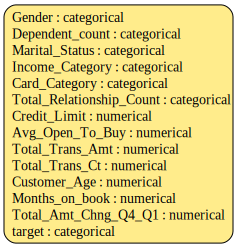

In [132]:
metadata.visualize()

In [133]:
%%time
ctgan_model = CTGANSynthesizer(
    metadata,
    enforce_rounding=True,
    epochs=300,
    verbose=True,
    enforce_min_max_values=True
)
ctgan_model.fit(real_data)

synthetic_data = ctgan_model.sample(num_rows=real_data.shape[0])
synthetic_data.head()

INFO:SingleTableSynthesizer:{'EVENT': 'Instance', 'TIMESTAMP': datetime.datetime(2024, 10, 28, 12, 16, 29, 307848), 'SYNTHESIZER CLASS NAME': 'CTGANSynthesizer', 'SYNTHESIZER ID': 'CTGANSynthesizer_1.16.1_4b89d79eda9641c5a80cd8dafdc52ae4'}
INFO:SingleTableSynthesizer:{'EVENT': 'Fit', 'TIMESTAMP': datetime.datetime(2024, 10, 28, 12, 16, 29, 314575), 'SYNTHESIZER CLASS NAME': 'CTGANSynthesizer', 'SYNTHESIZER ID': 'CTGANSynthesizer_1.16.1_4b89d79eda9641c5a80cd8dafdc52ae4', 'TOTAL NUMBER OF TABLES': 1, 'TOTAL NUMBER OF ROWS': 9114, 'TOTAL NUMBER OF COLUMNS': 14}
INFO:sdv.data_processing.data_processor:Fitting table  metadata
INFO:sdv.data_processing.data_processor:Fitting formatters for table 
INFO:sdv.data_processing.data_processor:Fitting constraints for table 
INFO:sdv.data_processing.data_processor:Setting the configuration for the ``HyperTransformer`` for table 
INFO:sdv.data_processing.data_processor:Fitting HyperTransformer for table 
INFO:SingleTableSynthesizer:{'EVENT': 'Fit proce

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Gen. (-0.98) | Discrim. (-0.07): 100%|██████████| 300/300 [05:02<00:00,  1.01s/it]
INFO:SingleTableSynthesizer:{'EVENT': 'Sample', 'TIMESTAMP': datetime.datetime(2024, 10, 28, 12, 21, 40, 788071), 'SYNTHESIZER CLASS NAME': 'CTGANSynthesizer', 'SYNTHESIZER ID': 'CTGANSynthesizer_1.16.1_4b89d79eda9641c5a80cd8dafdc52ae4', 'TOTAL NUMBER OF TABLES': 1, 'TOTAL NUMBER OF ROWS': 9114, 'TOTAL NUMBER OF COLUMNS': 14}


CPU times: user 20min 9s, sys: 14min 6s, total: 34min 16s
Wall time: 5min 12s


Gender  Dependent_count Marital_Status Income_Category Card_Category  \
0      F                3        Married  Less than $40K      Platinum   
1      M                3        Unknown     $40K - $60K          Blue   
2      F                2         Single  Less than $40K          Blue   
3      M                2        Married    $80K - $120K          Blue   
4      F                3         Single     $40K - $60K          Blue   

   Total_Relationship_Count  Credit_Limit  Avg_Open_To_Buy  Total_Trans_Amt  \
0                         2       34516.0          33521.5           8222.0   
1                         3        2033.5           1351.4           1426.0   
2                         3        2708.2           2758.3           1965.0   
3                         6       18571.9          32672.6           1661.0   
4                         3       19839.3           3352.5           2873.0   

   Total_Trans_Ct  Customer_Age  Months_on_book  Total_Amt_Chng_Q4_Q1  target  
0             112            40              29                 0.901       0  
1              64            46              40                 0.730       0  
2              29            34              27                 0.805       1  
3              32            43              32                 0.653       0  
4              37            43              32                 1.026       0

In [134]:
synthetic_data.shape

(9114, 14)

In [135]:
synthetic_data.to_csv('./synthetic data/synthetic_data_CTGAN_cls.csv', index=False)

# Генерация синтетических данных при помощи Байесовских сетей для задачи классификации

In [118]:
label_encoders = {}
real_data_enc = real_data.copy()

for column in real_data_enc.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    real_data_enc[column] = le.fit_transform(real_data_enc[column])
    label_encoders[column] = le

real_data_enc = real_data_enc.dropna()
real_data_enc

Gender  Dependent_count  Marital_Status  Income_Category  Card_Category  \
3346       1                4               1                2              0   
5204       1                1               2                2              0   
7675       0                2               1                1              0   
1021       1                3               1                3              3   
6508       0                2               1                4              0   
...      ...              ...             ...              ...            ...   
2391       1                4               2                2              0   
3809       0                5               1                4              0   
9889       0                3               2                1              3   
7915       0                0               0                4              0   
7551       0                3               1                4              0   

      Total_Relationship_Count  Credit_Limit  Avg_Open_To_Buy  \
3346                         3       22956.0          21549.0   
5204                         3       19090.0          19090.0   
7675                         5        2653.0           2653.0   
1021                         6       34516.0          34516.0   
6508                         5        1978.0           1978.0   
...                        ...           ...              ...   
2391                         5       12280.0          11295.0   
3809                         5        2950.0            950.0   
9889                         2       19713.0          19182.0   
7915                         6        1732.0           1732.0   
7551                         6        2725.0            208.0   

      Total_Trans_Amt  Total_Trans_Ct  Customer_Age  Months_on_book  \
3346           5554.0              64            40              36   
5204           4712.0              88            57              43   
7675           5052.0              81            55              36   
1021           1733.0              54            48              36   
6508           4870.0              83            56              43   
...               ...             ...           ...             ...   
2391           4263.0              70            46              40   
3809           4742.0              79            47              40   
9889           8301.0              70            43              36   
7915           2479.0              43            32              36   
7551           4430.0              66            43              34   

      Total_Amt_Chng_Q4_Q1  target  
3346                 0.709       0  
5204                 0.530       0  
7675                 0.969       0  
1021                 0.691       0  
6508                 0.641       0  
...                    ...     ...  
2391                 0.841       0  
3809                 0.882       0  
9889                 0.792       1  
7915                 0.683       1  
7551                 0.482       0  

[9114 rows x 14 columns]

In [119]:
cleaned_real_data = remove_outliers(real_data_enc, exclude_l=['target', 'Card_Category'])

print(f"Размер данных до очистки: {real_data_enc.shape}")
print(f"Размер данных после очистки: {cleaned_real_data.shape}")

Index(['Gender', 'Dependent_count', 'Marital_Status', 'Income_Category',
       'Total_Relationship_Count', 'Credit_Limit', 'Avg_Open_To_Buy',
       'Total_Trans_Amt', 'Total_Trans_Ct', 'Customer_Age', 'Months_on_book',
       'Total_Amt_Chng_Q4_Q1'],
      dtype='object')
Размер данных до очистки: (9114, 14)
Размер данных после очистки: (6875, 14)


In [121]:
# Выбираем непрерывные переменные
continuous_columns = cleaned_real_data.select_dtypes(include=['float64', 'int64']).columns
# Дискретизация с использованием равных интервалов (по умолчанию — 5 интервалов)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
# Применяем дискретизацию к непрерывным переменным
cleaned_real_data[continuous_columns] = discretizer.fit_transform(cleaned_real_data[continuous_columns])

In [122]:
hc = HillClimbSearch(cleaned_real_data)
# best_model = hc.estimate(scoring_method=BicScore(real_data))
best_model = hc.estimate(scoring_method=BDsScore(cleaned_real_data)) #  K2Score

model = BayesianNetwork(best_model.edges())
model.fit(real_data_enc, estimator=MaximumLikelihoodEstimator)


  0%|          | 22/1000000 [00:00<10:05:13, 27.54it/s]


In [123]:
#Генерация новых синтетических данных
sampler = BayesianModelSampling(model)

synthetic_samples = sampler.forward_sample(size=real_data_enc.shape[0])

synthetic_samples_df = pd.DataFrame(synthetic_samples)

synthetic_samples_df

Generating for node: Card_Category: 100%|██████████| 14/14 [00:04<00:00,  3.45it/s]  


Gender  Income_Category  Dependent_count  Customer_Age  Credit_Limit  \
0          1                3                1            31       34516.0   
1          1                2                1            39        2775.0   
2          0                4                1            59        1438.3   
3          1                4                3            41        2552.0   
4          1                4                4            54        3075.0   
...      ...              ...              ...           ...           ...   
9109       1                0                3            41       21144.0   
9110       0                5                0            44       11474.0   
9111       0                4                3            47        1728.0   
9112       1                1                3            45        3234.0   
9113       0                4                5            46        1438.3   

      Card_Category  Avg_Open_To_Buy  Total_Trans_Amt  \
0                 3          34302.0           4654.0   
1                 0           1111.0          14357.0   
2                 0           1438.3           3738.0   
3                 0            332.0           8586.0   
4                 0            558.0           8634.0   
...             ...              ...              ...   
9109              0           3439.0           4697.0   
9110              0          10411.0           2234.0   
9111              0           1728.0           4669.0   
9112              0           1720.0            715.0   
9113              0            460.3           1950.0   

      Total_Relationship_Count  Total_Amt_Chng_Q4_Q1  Marital_Status  \
0                            5                 0.690               2   
1                            3                 0.689               1   
2                            4                 0.443               0   
3                            1                 1.148               0   
4                            5                 0.638               2   
...                        ...                   ...             ...   
9109                         5                 0.878               1   
9110                         5                 0.278               3   
9111                         1                 0.853               0   
9112                         2                 0.819               3   
9113                         4                 0.673               1   

      Total_Trans_Ct  target  Months_on_book  
0                 69       0              26  
1                120       0              27  
2                 87       0              22  
3                 68       1              36  
4                105       0              36  
...              ...     ...             ...  
9109              92       0              33  
9110              59       1              34  
9111             104       0              36  
9112              35       1              40  
9113              41       0              27  

[9114 rows x 14 columns]

In [125]:
synthetic_samples_df.shape

(9114, 14)

In [126]:
cleared_synthetic_samples_df = remove_outliers(synthetic_samples_df)
cleared_synthetic_samples_df.shape

Index(['Gender', 'Income_Category', 'Dependent_count', 'Customer_Age',
       'Credit_Limit', 'Card_Category', 'Avg_Open_To_Buy', 'Total_Trans_Amt',
       'Total_Relationship_Count', 'Total_Amt_Chng_Q4_Q1', 'Marital_Status',
       'Total_Trans_Ct', 'target', 'Months_on_book'],
      dtype='object')


(4095, 14)

In [127]:
# Декодируем обратно категориальные переменные
for column, le in label_encoders.items():
    synthetic_samples_df[column] = le.inverse_transform(synthetic_samples_df[column])

synthetic_samples_df

Gender Income_Category  Dependent_count  Customer_Age  Credit_Limit  \
0         M    $80K - $120K                1            31       34516.0   
1         M     $60K - $80K                1            39        2775.0   
2         F  Less than $40K                1            59        1438.3   
3         M  Less than $40K                3            41        2552.0   
4         M  Less than $40K                4            54        3075.0   
...     ...             ...              ...           ...           ...   
9109      M         $120K +                3            41       21144.0   
9110      F         Unknown                0            44       11474.0   
9111      F  Less than $40K                3            47        1728.0   
9112      M     $40K - $60K                3            45        3234.0   
9113      F  Less than $40K                5            46        1438.3   

     Card_Category  Avg_Open_To_Buy  Total_Trans_Amt  \
0           Silver          34302.0           4654.0   
1             Blue           1111.0          14357.0   
2             Blue           1438.3           3738.0   
3             Blue            332.0           8586.0   
4             Blue            558.0           8634.0   
...            ...              ...              ...   
9109          Blue           3439.0           4697.0   
9110          Blue          10411.0           2234.0   
9111          Blue           1728.0           4669.0   
9112          Blue           1720.0            715.0   
9113          Blue            460.3           1950.0   

      Total_Relationship_Count  Total_Amt_Chng_Q4_Q1 Marital_Status  \
0                            5                 0.690         Single   
1                            3                 0.689        Married   
2                            4                 0.443       Divorced   
3                            1                 1.148       Divorced   
4                            5                 0.638         Single   
...                        ...                   ...            ...   
9109                         5                 0.878        Married   
9110                         5                 0.278        Unknown   
9111                         1                 0.853       Divorced   
9112                         2                 0.819        Unknown   
9113                         4                 0.673        Married   

      Total_Trans_Ct  target  Months_on_book  
0                 69       0              26  
1                120       0              27  
2                 87       0              22  
3                 68       1              36  
4                105       0              36  
...              ...     ...             ...  
9109              92       0              33  
9110              59       1              34  
9111             104       0              36  
9112              35       1              40  
9113              41       0              27  

[9114 rows x 14 columns]

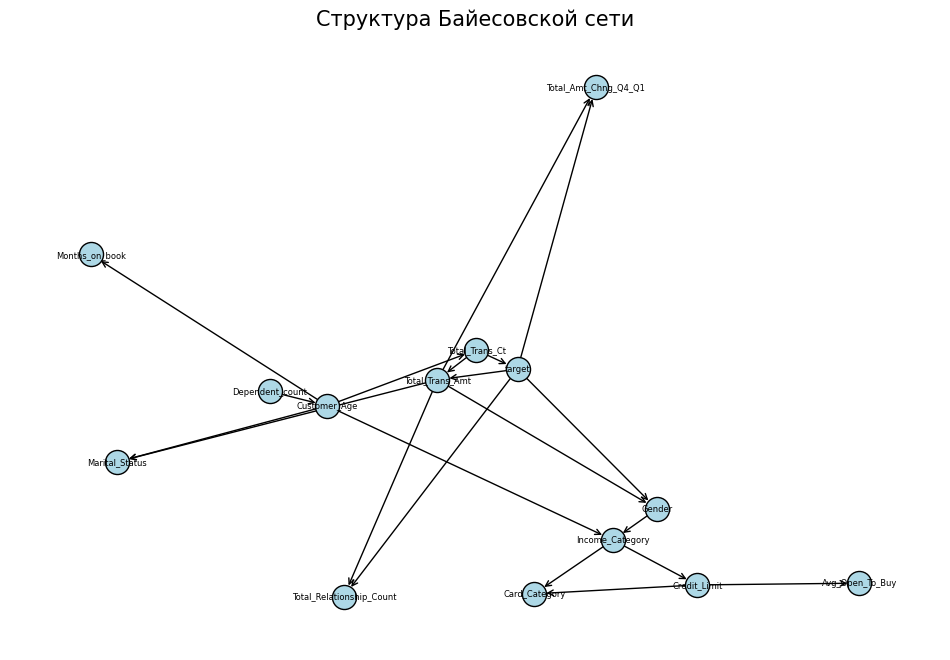

In [128]:
# Получаем структуру графа из модели
edges = best_model.edges()
G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', edgecolors='black')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10)
nx.draw_networkx_labels(G, pos, font_size=6, font_family='sans-serif')

plt.title("Структура Байесовской сети", fontsize=15)
plt.axis('off')
plt.show()

In [129]:
synthetic_samples_df.to_csv('./synthetic data/synthetic_data_BN_cls.csv', index=False)

 # Сравнение реальных и синтетических данных для задачи классификации

In [136]:
synthetic_data_ctgan = pd.read_csv('./synthetic data/synthetic_data_CTGAN_cls.csv')
synthetic_data_bamt = pd.read_csv('./synthetic data/synthetic_data_BN_cls.csv')
loaded_metadata = SingleTableMetadata.load_from_json('./data/metadata_cls.json')

synthetic_data_ctgan.shape, synthetic_data_bamt.shape 

((9114, 14), (9114, 14))

In [137]:
synthetic_data_bamt.dtypes

Gender                       object
Income_Category              object
Dependent_count               int64
Customer_Age                  int64
Credit_Limit                float64
Card_Category                object
Avg_Open_To_Buy             float64
Total_Trans_Amt             float64
Total_Relationship_Count      int64
Total_Amt_Chng_Q4_Q1        float64
Marital_Status               object
Total_Trans_Ct                int64
target                        int64
Months_on_book                int64
dtype: object

In [138]:
synthetic_data_ctgan.dtypes

Gender                       object
Dependent_count               int64
Marital_Status               object
Income_Category              object
Card_Category                object
Total_Relationship_Count      int64
Credit_Limit                float64
Avg_Open_To_Buy             float64
Total_Trans_Amt             float64
Total_Trans_Ct                int64
Customer_Age                  int64
Months_on_book                int64
Total_Amt_Chng_Q4_Q1        float64
target                        int64
dtype: object

In [139]:
real_data.dtypes

Gender                       object
Dependent_count               int64
Marital_Status               object
Income_Category              object
Card_Category                object
Total_Relationship_Count      int64
Credit_Limit                float64
Avg_Open_To_Buy             float64
Total_Trans_Amt             float64
Total_Trans_Ct                int64
Customer_Age                  int64
Months_on_book                int64
Total_Amt_Chng_Q4_Q1        float64
target                        int64
dtype: object

In [140]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic_ctgan = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data_ctgan,
    metadata=metadata
)

diagnostic_bamt = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data_bamt,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 243.73it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 68.79it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 1154.96it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 1209.43it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [141]:
diagnostic_ctgan.get_details(property_name='Data Validity')

Column             Metric  Score
0                     Gender  CategoryAdherence    1.0
1            Dependent_count  CategoryAdherence    1.0
2             Marital_Status  CategoryAdherence    1.0
3            Income_Category  CategoryAdherence    1.0
4              Card_Category  CategoryAdherence    1.0
5   Total_Relationship_Count  CategoryAdherence    1.0
6               Credit_Limit  BoundaryAdherence    1.0
7            Avg_Open_To_Buy  BoundaryAdherence    1.0
8            Total_Trans_Amt  BoundaryAdherence    1.0
9             Total_Trans_Ct  BoundaryAdherence    1.0
10              Customer_Age  BoundaryAdherence    1.0
11            Months_on_book  BoundaryAdherence    1.0
12      Total_Amt_Chng_Q4_Q1  BoundaryAdherence    1.0
13                    target  CategoryAdherence    1.0

In [142]:
diagnostic_bamt.get_details(property_name='Data Validity')

Column             Metric  Score
0                     Gender  CategoryAdherence    1.0
1            Dependent_count  CategoryAdherence    1.0
2             Marital_Status  CategoryAdherence    1.0
3            Income_Category  CategoryAdherence    1.0
4              Card_Category  CategoryAdherence    1.0
5   Total_Relationship_Count  CategoryAdherence    1.0
6               Credit_Limit  BoundaryAdherence    1.0
7            Avg_Open_To_Buy  BoundaryAdherence    1.0
8            Total_Trans_Amt  BoundaryAdherence    1.0
9             Total_Trans_Ct  BoundaryAdherence    1.0
10              Customer_Age  BoundaryAdherence    1.0
11            Months_on_book  BoundaryAdherence    1.0
12      Total_Amt_Chng_Q4_Q1  BoundaryAdherence    1.0
13                    target  CategoryAdherence    1.0

In [143]:
from sdv.evaluation.single_table import evaluate_quality

quality_report_ctgan = evaluate_quality(
    real_data=real_data,
    synthetic_data=synthetic_data_ctgan,
    metadata=metadata
)

quality_report_bamt = evaluate_quality(
    real_data=real_data,
    synthetic_data=synthetic_data_bamt,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 176.95it/s]|
Column Shapes Score: 91.92%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:01<00:00, 73.56it/s]|
Column Pair Trends Score: 85.39%

Overall Score (Average): 88.66%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 361.92it/s]|
Column Shapes Score: 90.03%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:01<00:00, 79.62it/s]|
Column Pair Trends Score: 84.92%

Overall Score (Average): 87.48%



In [144]:
ctgan_report = quality_report_ctgan.get_details('Column Shapes')
ctgan_report.rename(columns={'Score': 'CTGAN_score'}, inplace=True)

bamt_report = quality_report_bamt.get_details('Column Shapes')
bamt_report.rename(columns={'Score': 'BN_score'}, inplace=True)

adj_report = pd.concat([ctgan_report, bamt_report.BN_score], axis=1)
adj_report

Column        Metric  CTGAN_score  BN_score
0                     Gender  TVComplement     0.946675  0.931644
1            Dependent_count  TVComplement     0.946456  0.989686
2             Marital_Status  TVComplement     0.895765  0.684661
3            Income_Category  TVComplement     0.905749  0.971472
4              Card_Category  TVComplement     0.929778  0.833553
5   Total_Relationship_Count  TVComplement     0.814681  0.937788
6               Credit_Limit  KSComplement     0.920123  0.991442
7            Avg_Open_To_Buy  KSComplement     0.905311  0.784178
8            Total_Trans_Amt  KSComplement     0.915734  0.861422
9             Total_Trans_Ct  KSComplement     0.923195  0.976081
10              Customer_Age  KSComplement     0.964779  0.990454
11            Months_on_book  KSComplement     0.930985  0.799868
12      Total_Amt_Chng_Q4_Q1  KSComplement     0.890937  0.898398
13                    target  TVComplement     0.979043  0.954136

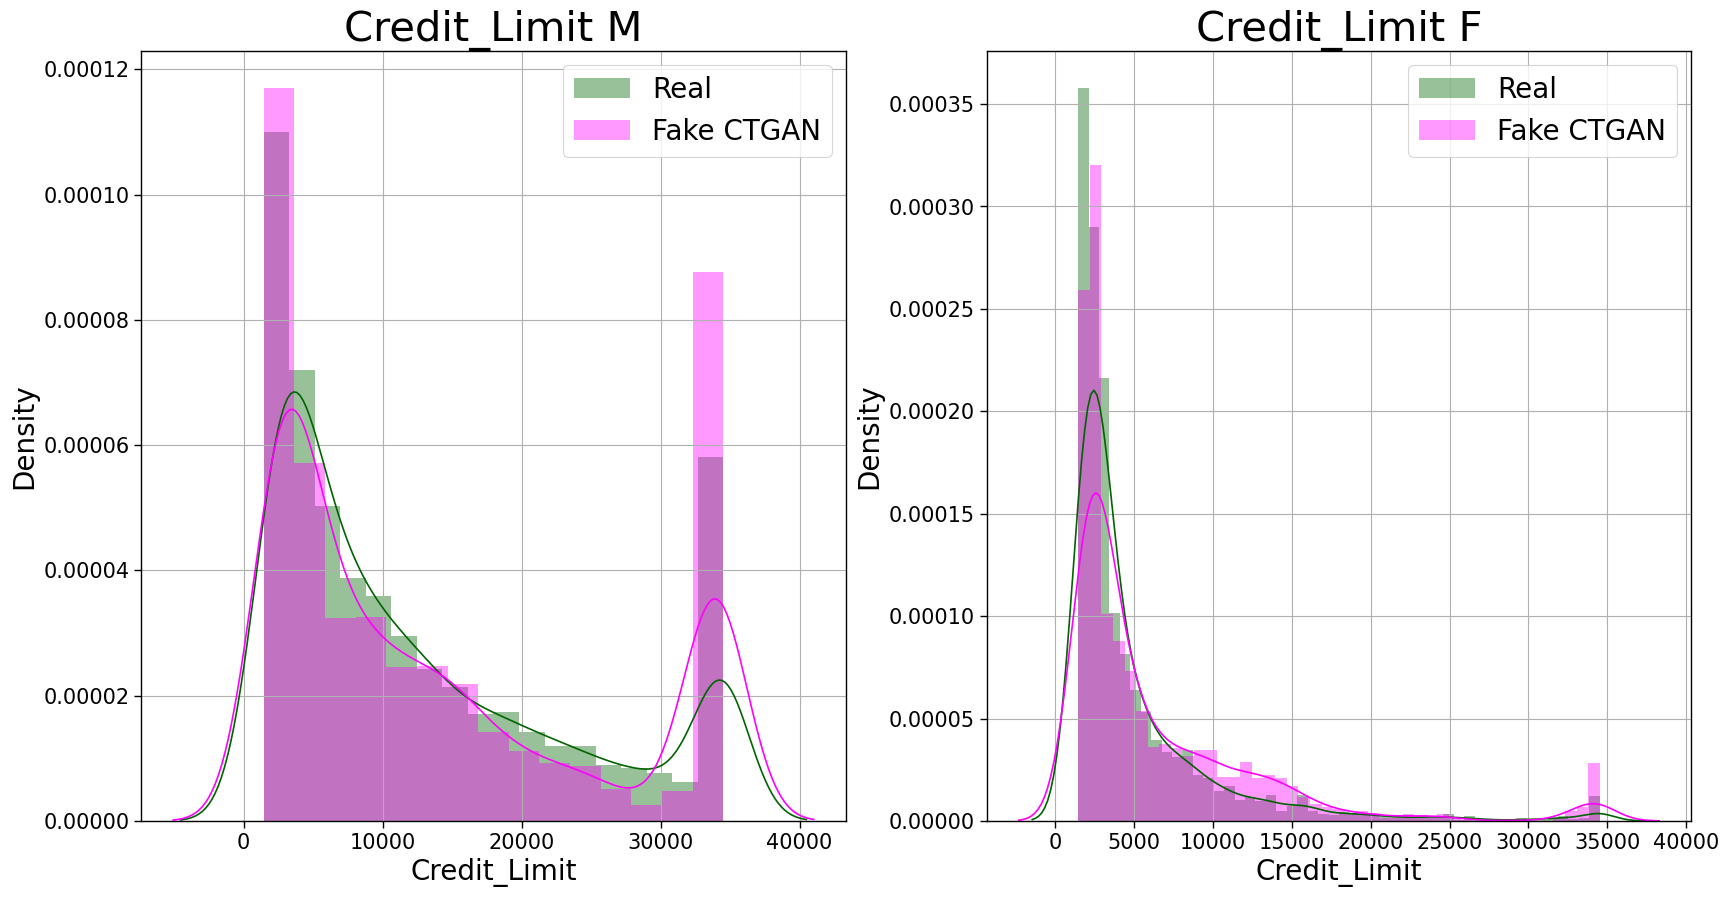

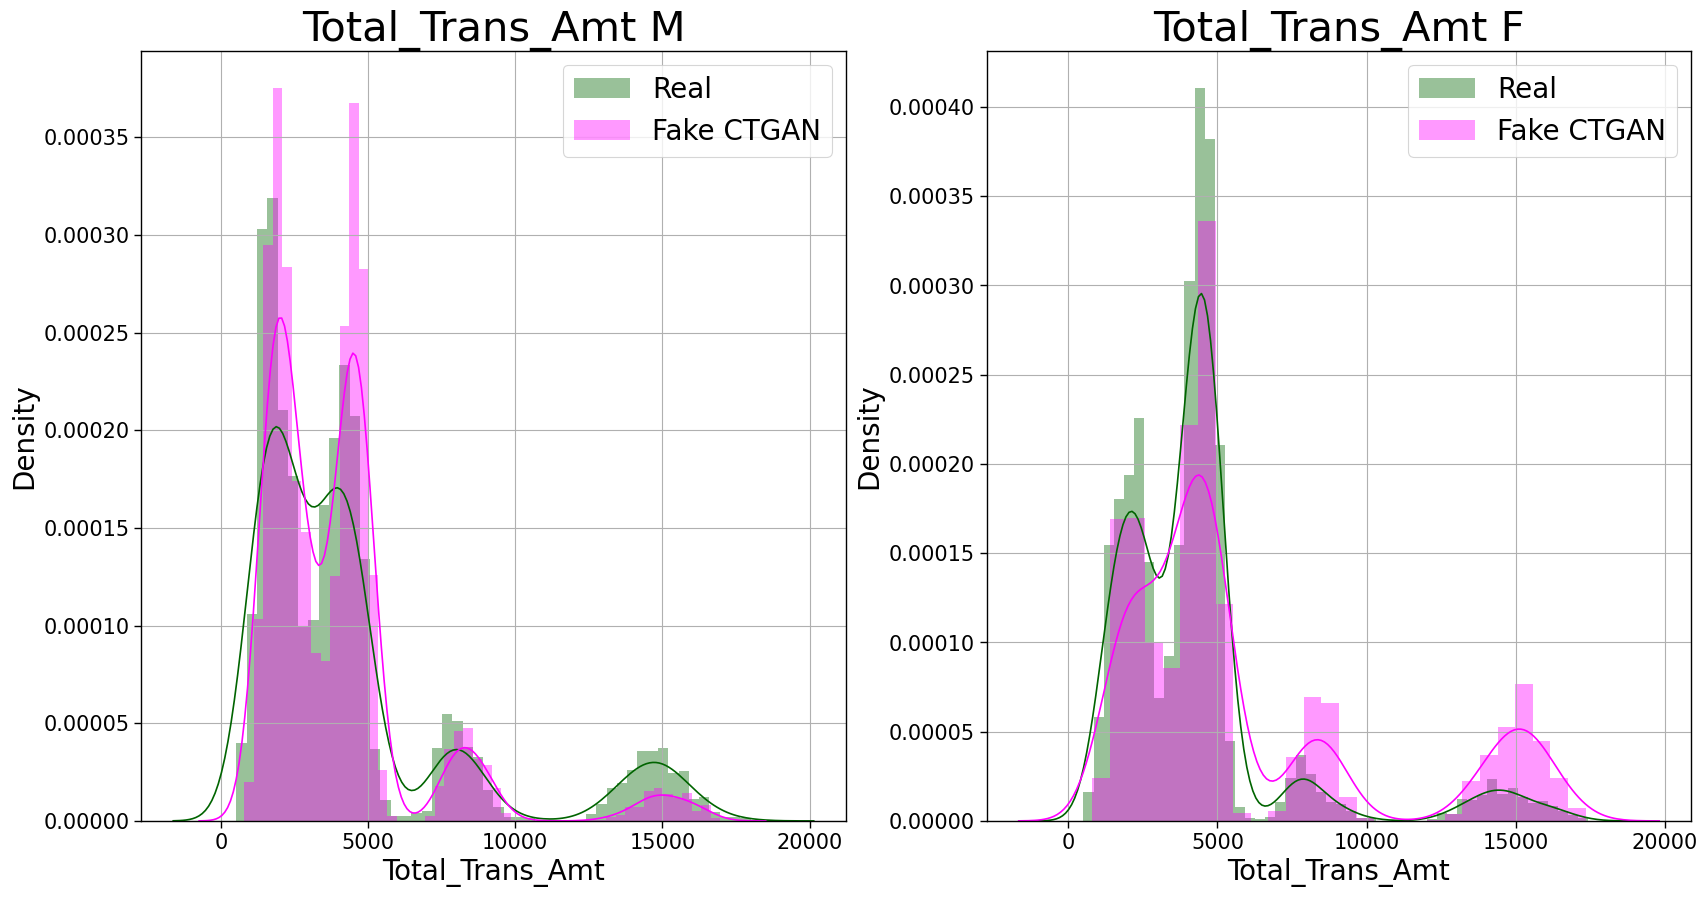

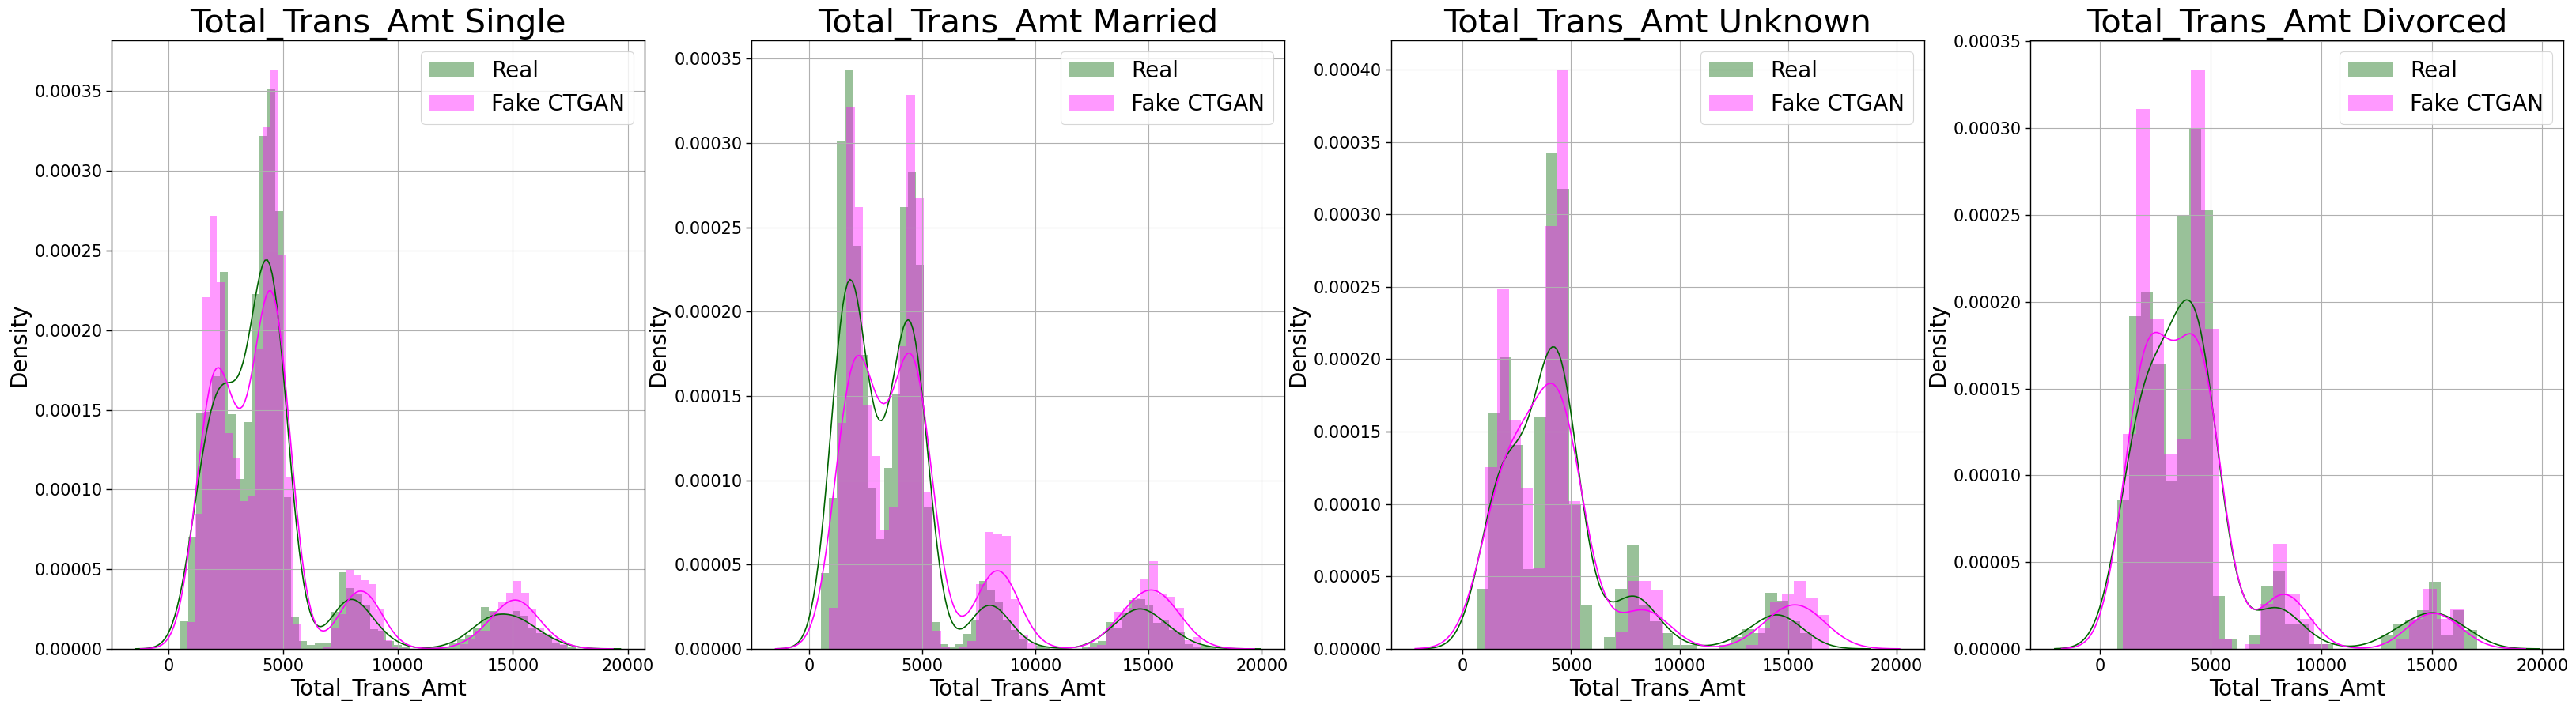

In [145]:
plot_cols = {'Gender': ['Credit_Limit', 'Total_Trans_Amt'],
            'Marital_Status': ['Total_Trans_Amt']}

sns.set_context("paper", rc={"axes.titlesize":30,"axes.labelsize":20, "legend.fontsize": 20, "xtick.labelsize":15, "ytick.labelsize":15})
for cat_name in plot_cols:
  cats = synthetic_data_ctgan[cat_name].value_counts().index
  for col in plot_cols[cat_name]:
    fig, ax= plt.subplots(1, len(cats), figsize=(10*len(cats), 10),)
    for i, cat in enumerate(cats):
      sns.distplot(X_train[X_train[cat_name]==cat][col], ax=ax[i], label='Real', color=REAL_COLOR)
      sns.distplot(synthetic_data_ctgan[synthetic_data_ctgan[cat_name]==cat][col], ax=ax[i], label='Fake CTGAN', color=CTGAN_COLOR)
      ax[i].grid(True)
      ax[i].set_title(f'{col} {cat}')
      ax[i].legend(loc=0)

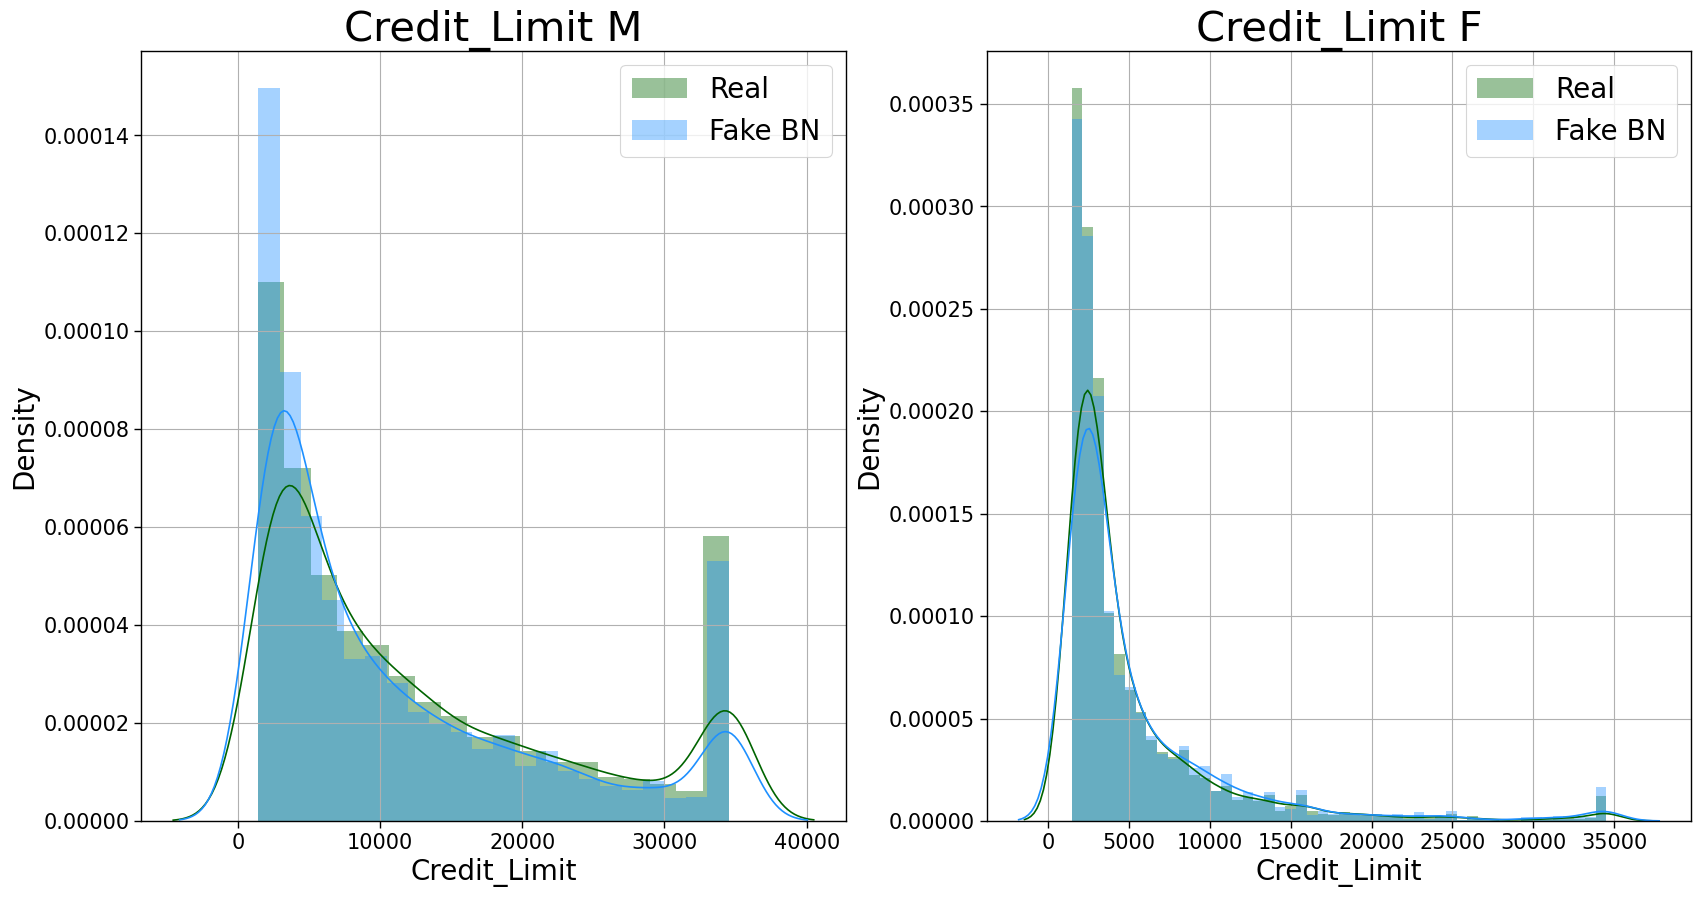

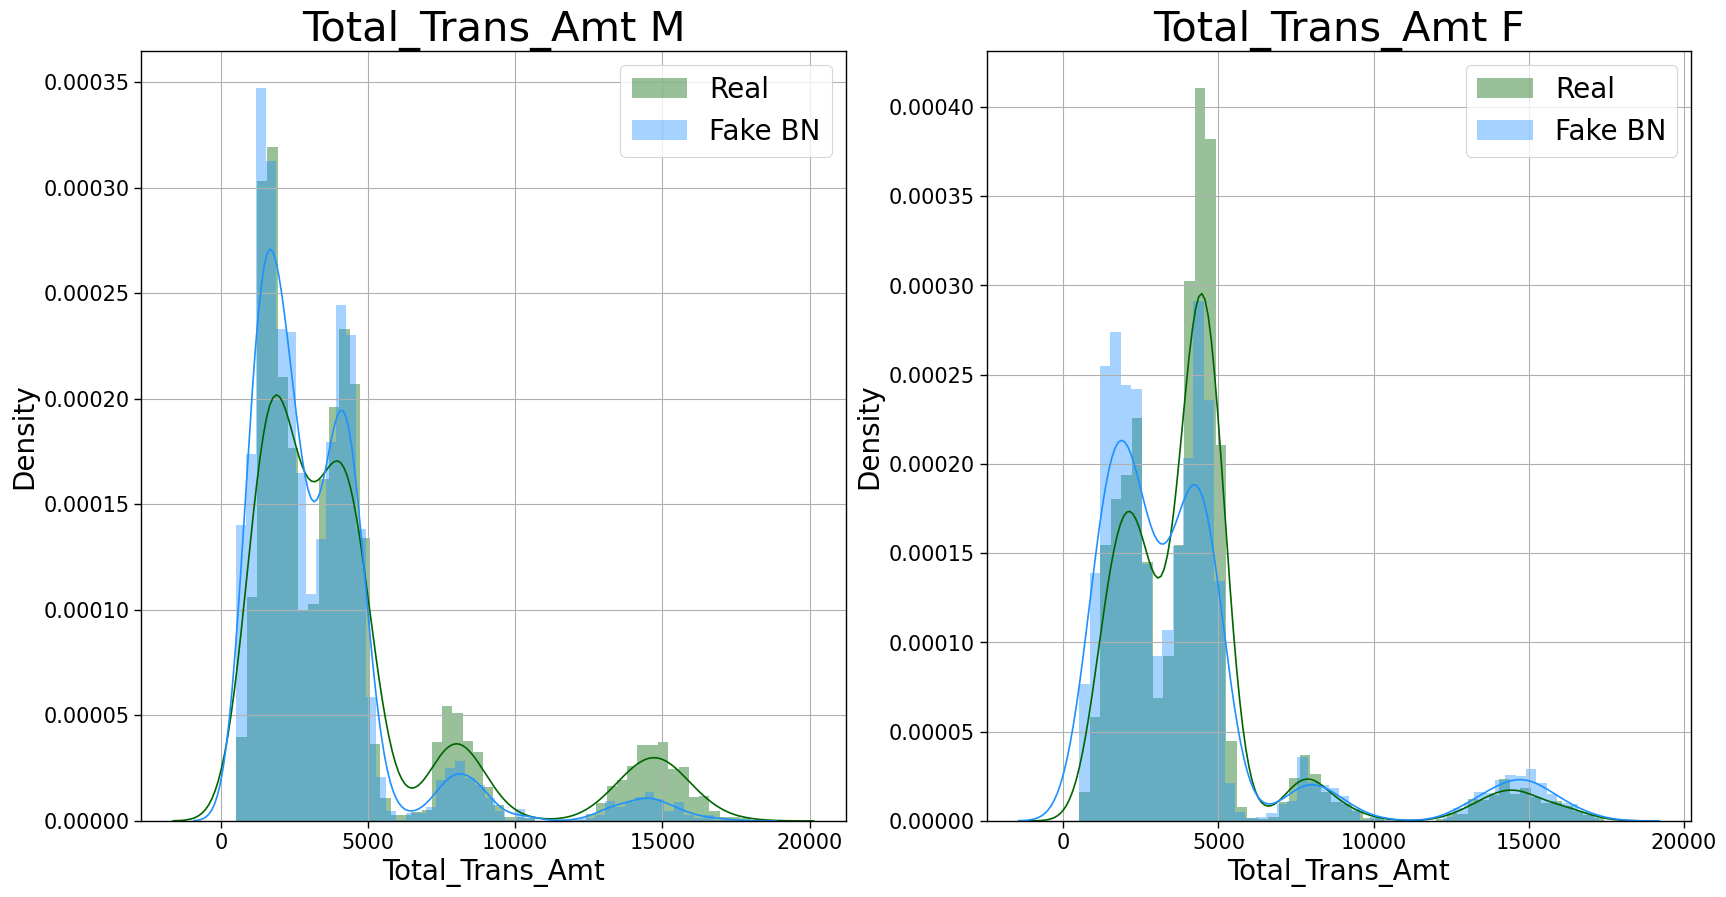

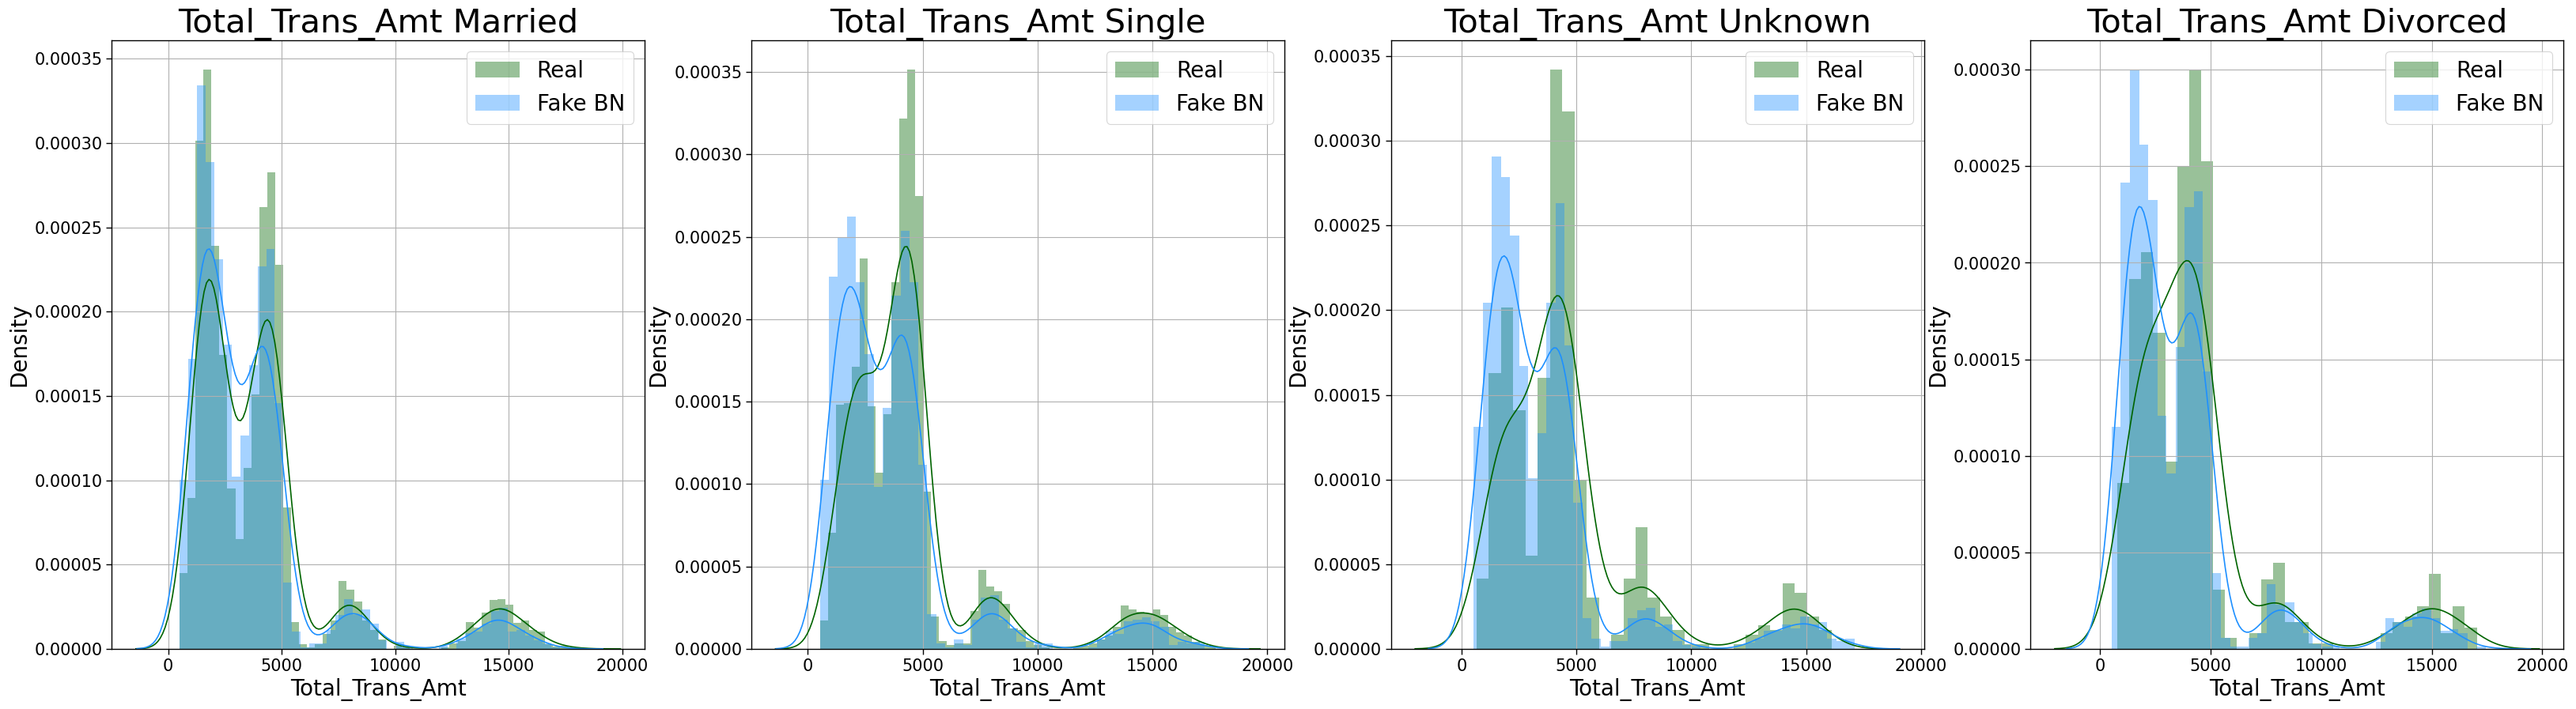

In [146]:
plot_cols = {'Gender': ['Credit_Limit', 'Total_Trans_Amt'],
            'Marital_Status': ['Total_Trans_Amt']}

sns.set_context("paper", rc={"axes.titlesize":30,"axes.labelsize":20, "legend.fontsize": 20, "xtick.labelsize":15, "ytick.labelsize":15})
for cat_name in plot_cols:
  cats = synthetic_data_bamt[cat_name].value_counts().index
  for col in plot_cols[cat_name]:
    fig, ax= plt.subplots(1, len(cats), figsize=(10*len(cats), 10),)
    for i, cat in enumerate(cats):
      sns.distplot(X_train[X_train[cat_name]==cat][col], ax=ax[i], label='Real', color=REAL_COLOR)
      sns.distplot(synthetic_data_bamt[synthetic_data_bamt[cat_name]==cat][col], ax=ax[i], label='Fake BN', color=BAMT_COLOR)
      ax[i].grid(True)
      ax[i].set_title(f'{col} {cat}')
      ax[i].legend(loc=0)

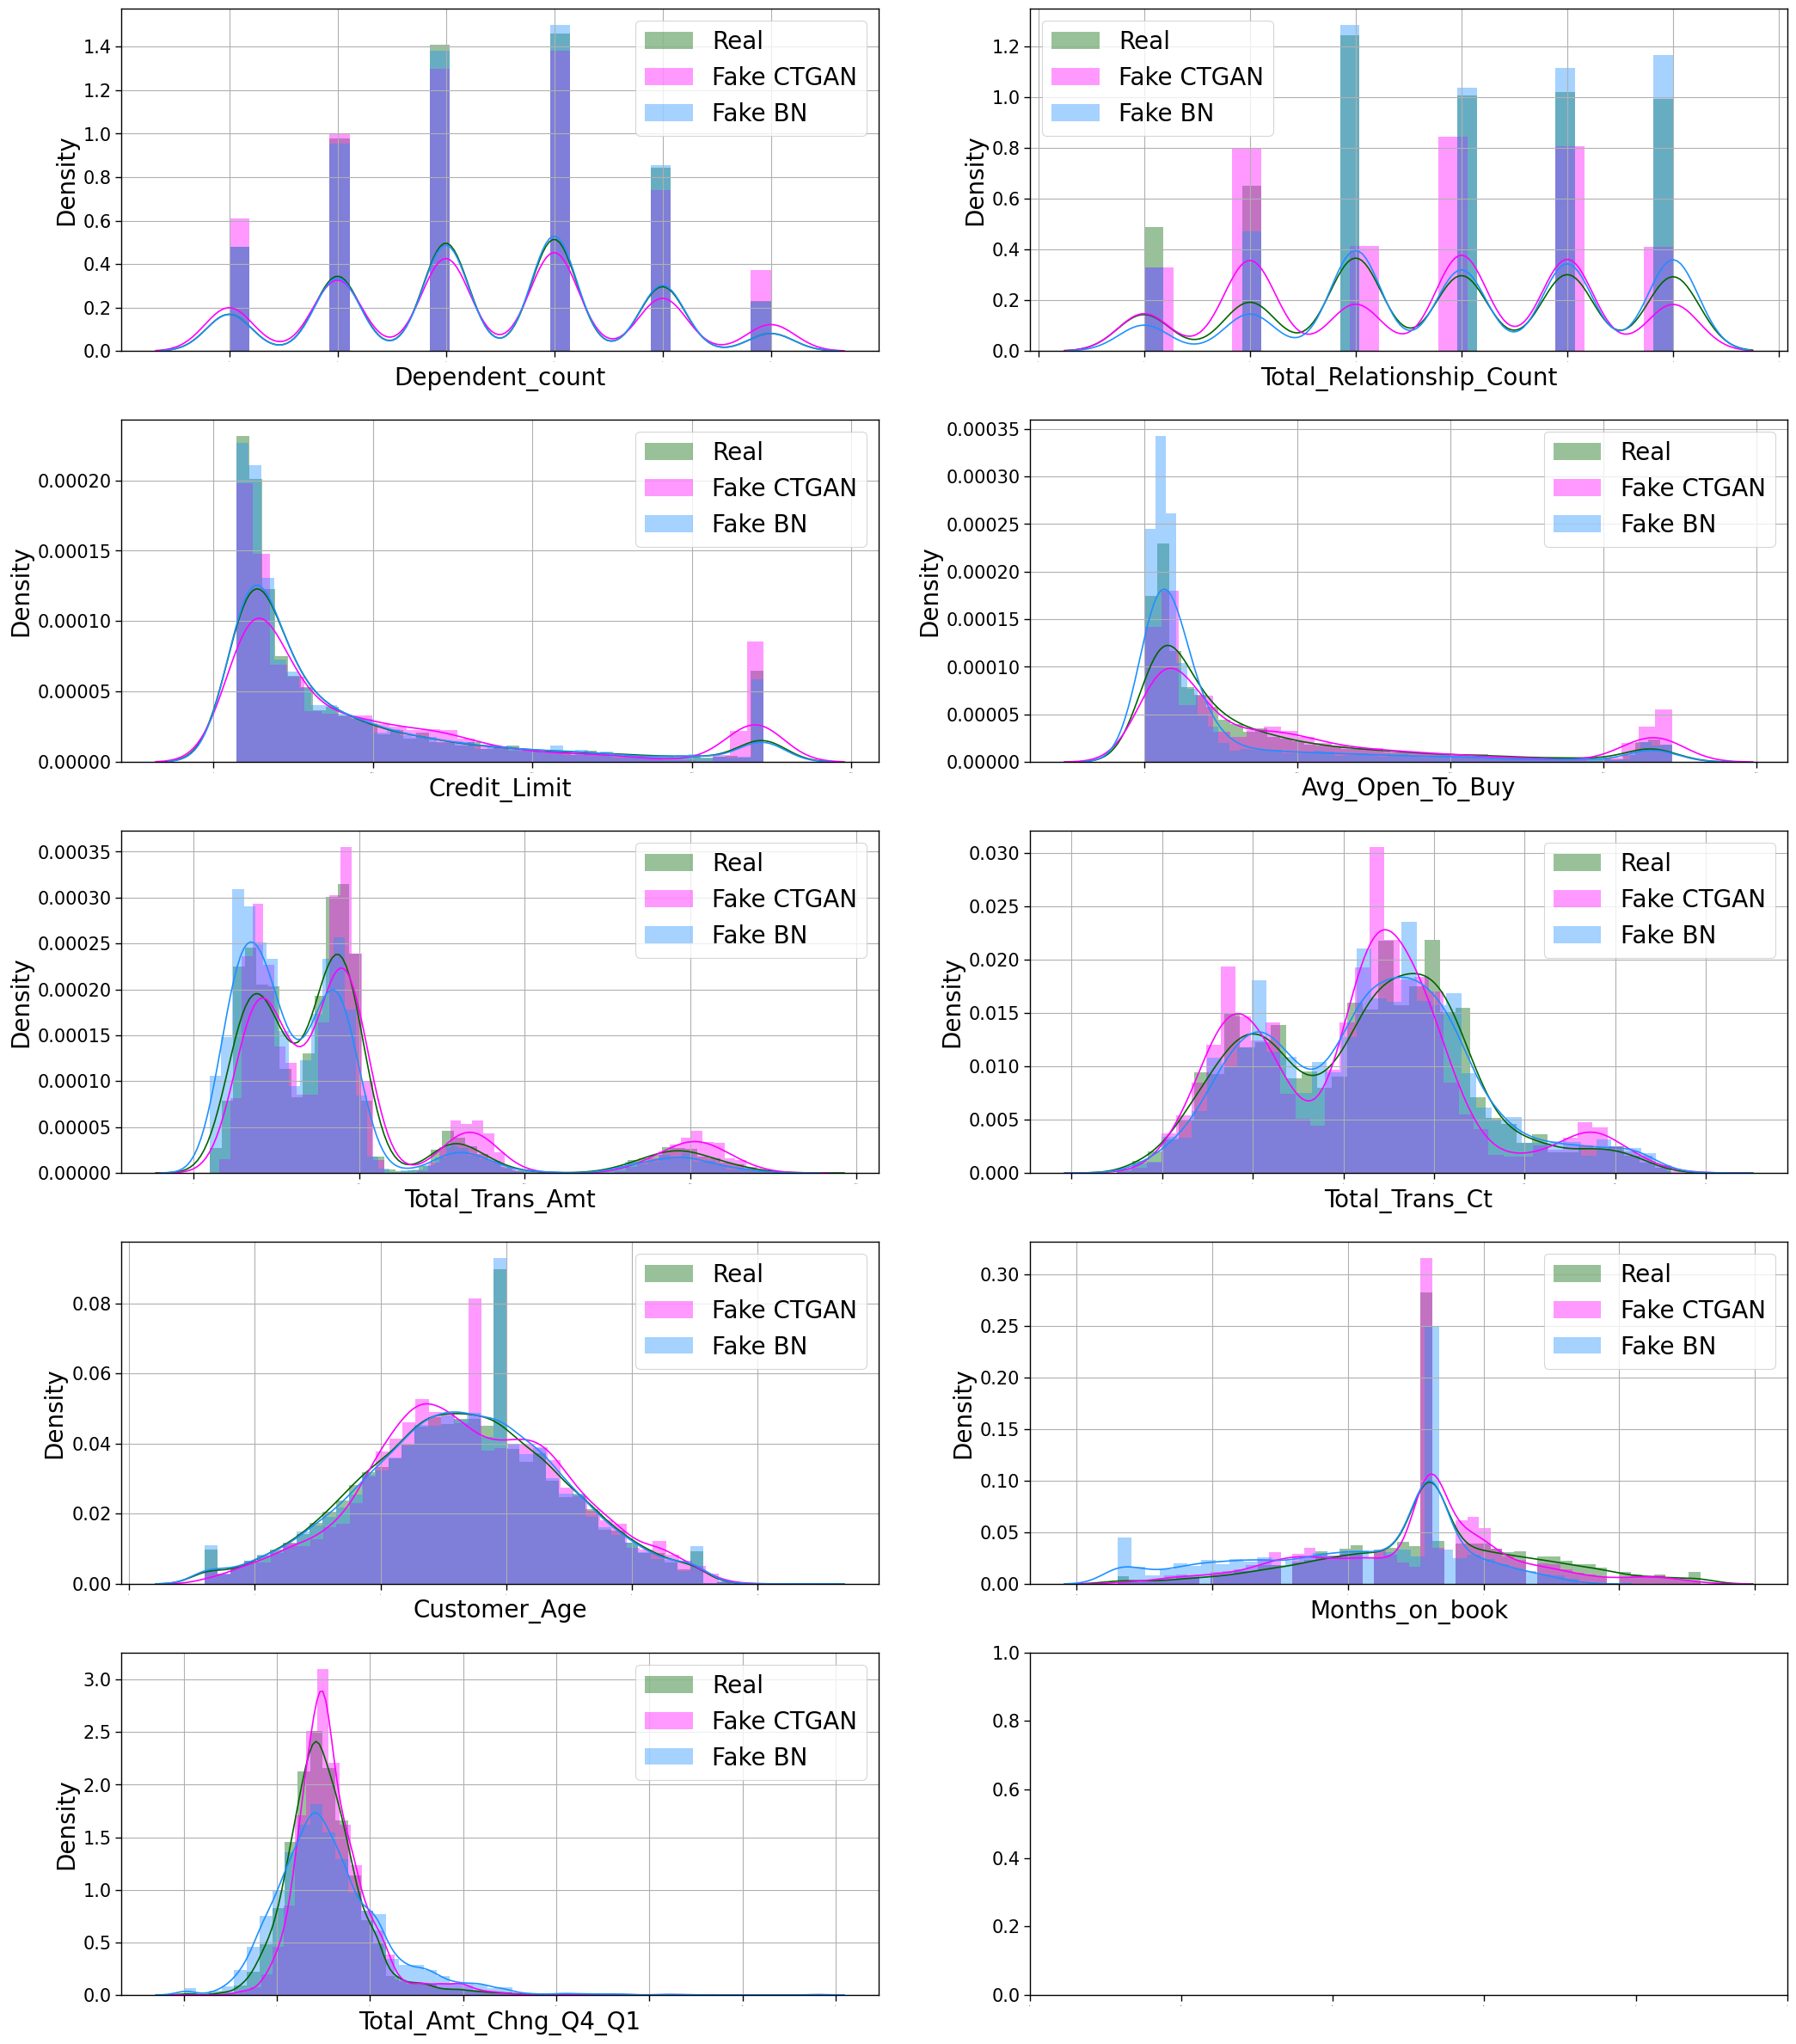

In [149]:
cont_data = [ c for c in X_train.columns if c not in categorical_features]
cols = 2

rows = max(1 , len(cont_data) // cols) + 1

sns.set_context("paper", rc={"axes.titlesize":30,"axes.labelsize":20, "legend.fontsize": 20, "xtick.labelsize":1, "ytick.labelsize":15})

fig, ax= plt.subplots(rows, cols, figsize=(25, 6 * rows))

axes = ax.flatten()

for i, col in enumerate(cont_data):
  sns.distplot(X_train[col], ax=axes[i], label='Real', color = REAL_COLOR)
  sns.distplot(synthetic_data_ctgan[col], ax=axes[i], label='Fake CTGAN', color = CTGAN_COLOR)#, hist=False)
  sns.distplot(synthetic_data_bamt[col], ax=axes[i], label='Fake BN', color = BAMT_COLOR)

  axes[i].grid(True)
  axes[i].legend(loc=0)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

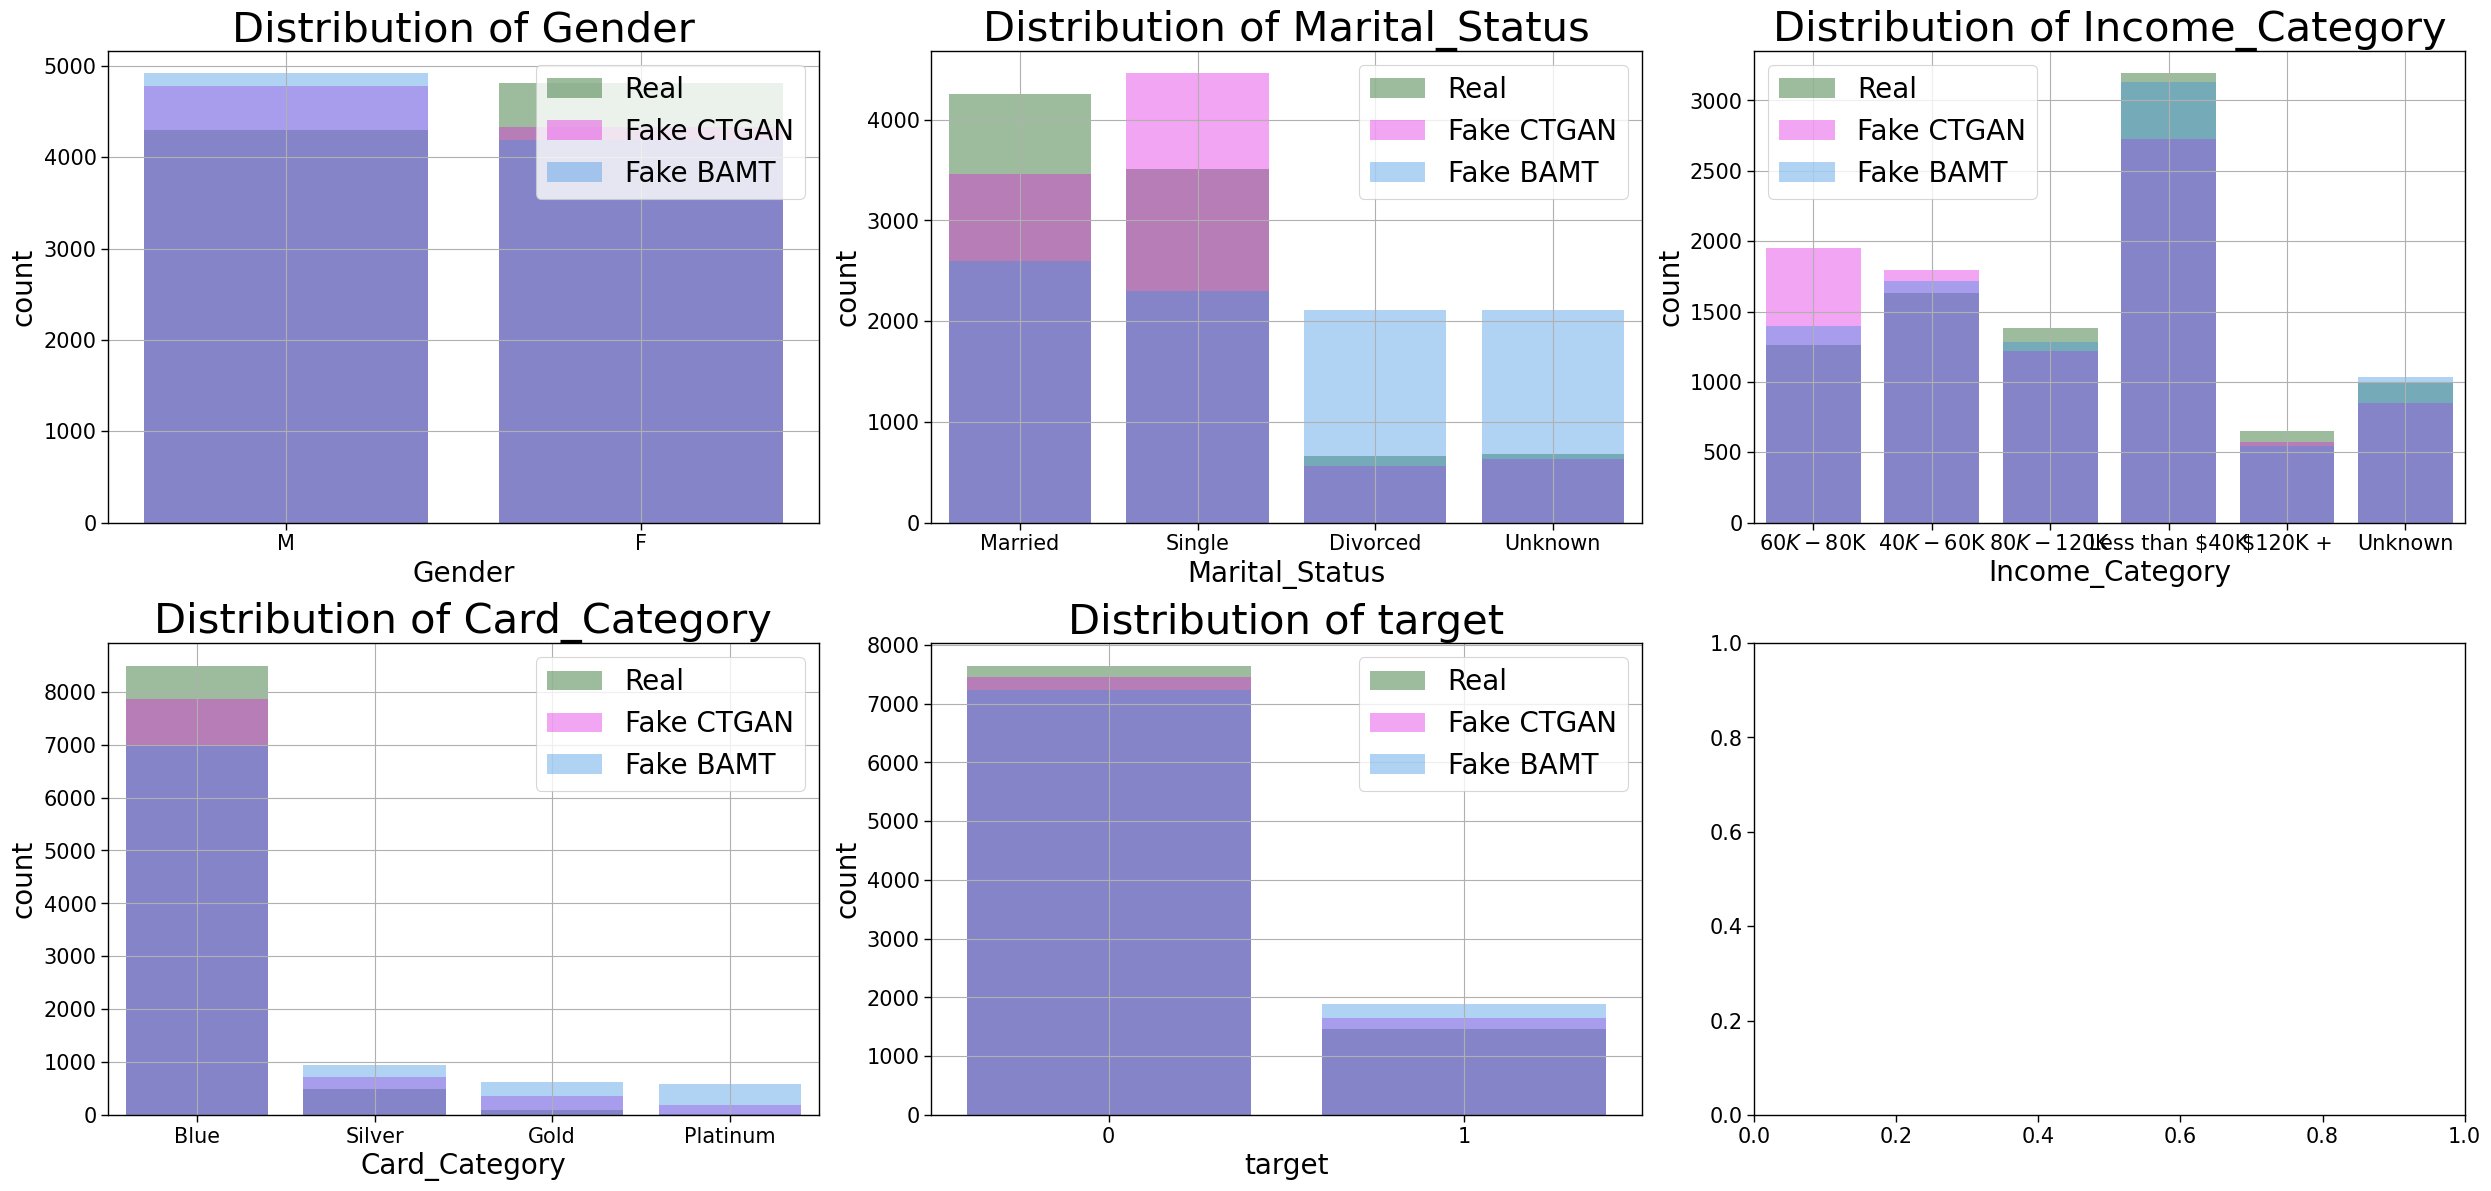

In [150]:
if 'target' not in categorical_features:
  categorical_features.append('target')

cols = 3
rows = (len(categorical_features) + cols - 1) // cols

sns.set_context("paper", rc={"axes.titlesize":30, "axes.labelsize":20, "legend.fontsize":20, "xtick.labelsize":15, "ytick.labelsize":15})

fig, ax = plt.subplots(rows, cols, figsize=(25, 6 * rows))
axes = ax.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=real_data[col], ax=axes[i], label='Real', color=REAL_COLOR, alpha=0.4)
    sns.countplot(x=synthetic_data_ctgan[col], ax=axes[i], label='Fake CTGAN', color=CTGAN_COLOR, alpha=0.4)
    sns.countplot(x=synthetic_data_bamt[col], ax=axes[i], label='Fake BAMT', color=BAMT_COLOR, alpha=0.4)

    axes[i].grid(True)
    axes[i].legend(loc=0)
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

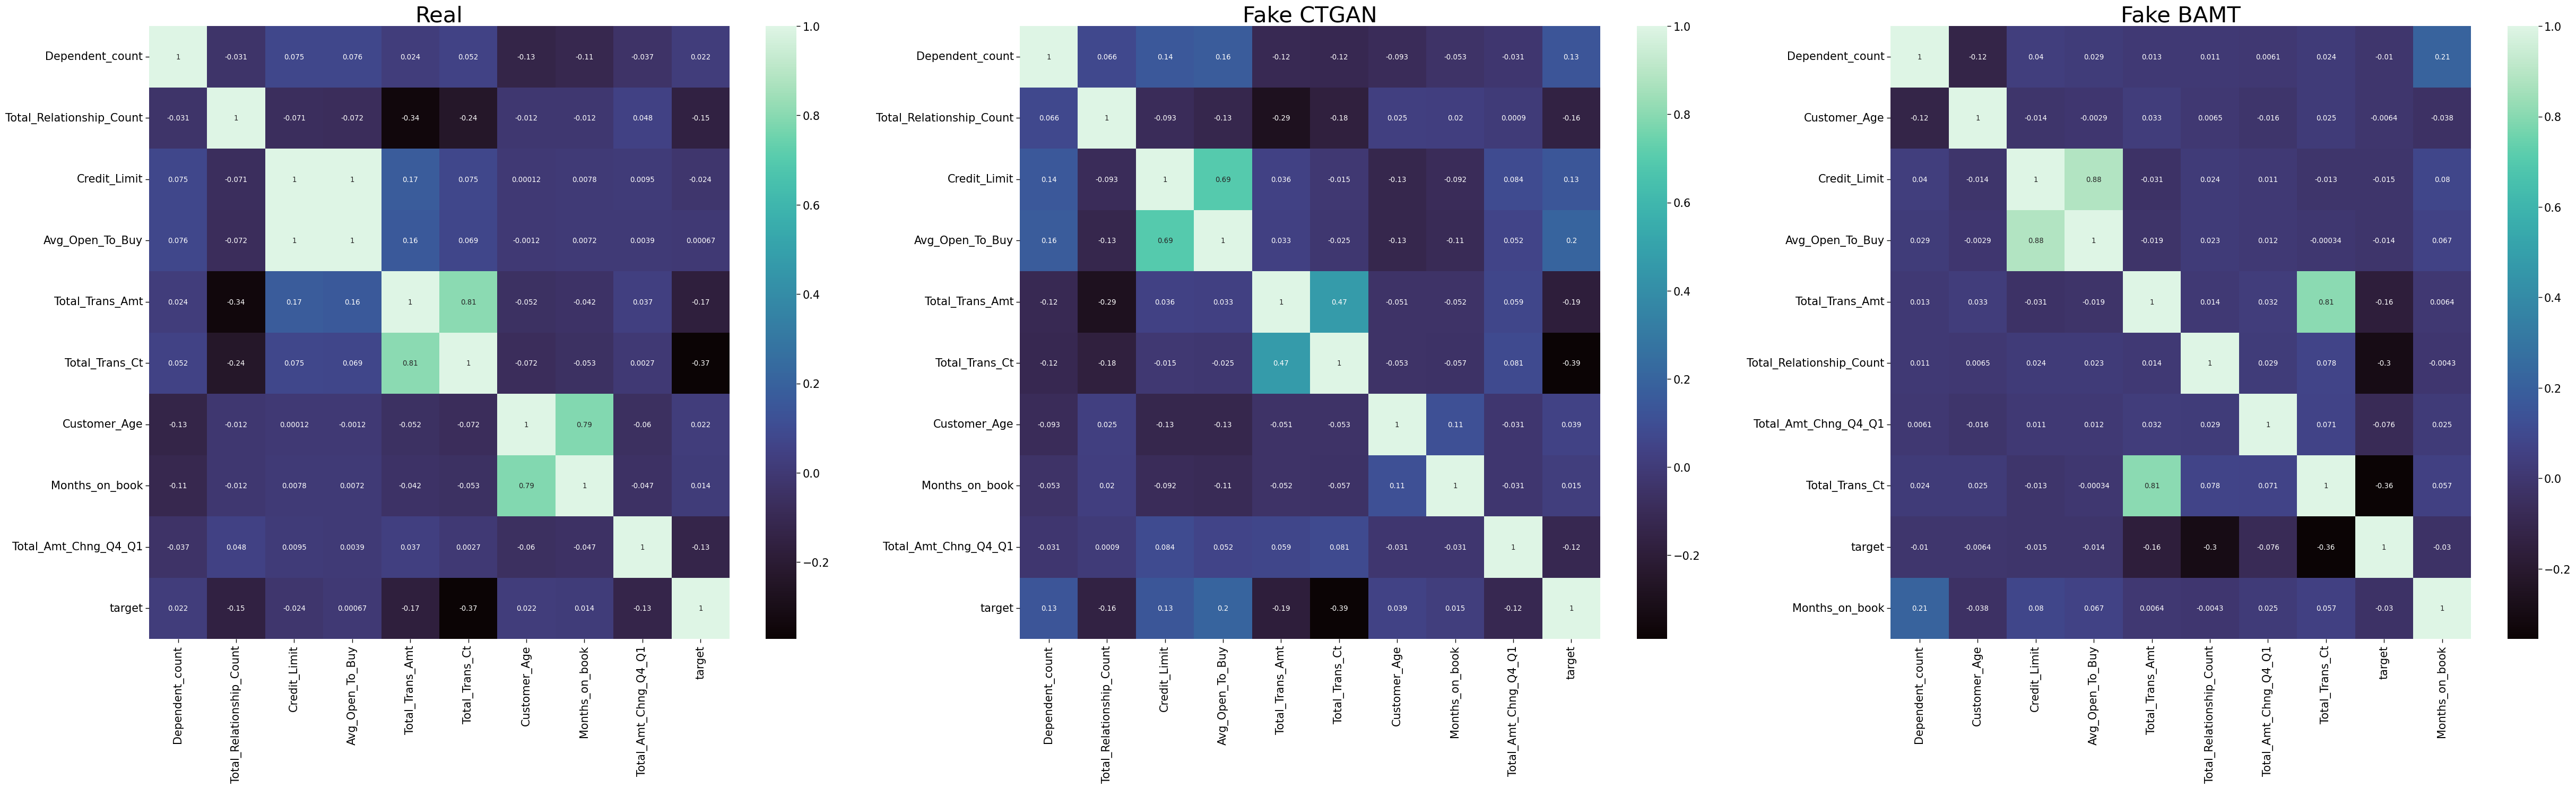

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(60, 15))

cmap = sns.color_palette("mako", as_cmap=True)

sns.heatmap(real_data.select_dtypes(exclude=['object']).corr(), ax=axes[0], annot=True, cmap=cmap)
sns.heatmap(synthetic_data_ctgan.select_dtypes(exclude=['object']).corr(), ax=axes[1], annot=True, cmap=cmap)
sns.heatmap(synthetic_data_bamt.select_dtypes(exclude=['object']).corr(), ax=axes[2], annot=True, cmap=cmap)

axes[0].set_title('Real')
axes[1].set_title('Fake CTGAN')
axes[2].set_title('Fake BAMT')
fig.show()

# Классификация. Предсказывание отточных клиентов

In [160]:
categorical_features = list(data.select_dtypes('object').columns)
categorical_features

['Gender', 'Marital_Status', 'Income_Category', 'Card_Category']

In [161]:
LR_pipe = Pipeline([
    ('encoding', ce.OrdinalEncoder(
       encoding_method='arbitrary', variables=categorical_features)),
    ('scaler', StandardScaler()),
    ('LR', LogisticRegression())
    ])

RF_pipe = Pipeline([
    ('encoding', ce.OrdinalEncoder(
       encoding_method='arbitrary', variables=categorical_features)),
    ('scaler', StandardScaler()),
    ('RF', RandomForestClassifier())
    ])

RFL_pipe = Pipeline([
    ('encoding', ce.OrdinalEncoder(
       encoding_method='ordered', variables=categorical_features)),
    ('scaler', StandardScaler()),
    ('RF', RandomForestRegressor())
    ])

In [162]:
for col in categorical_features:
    synthetic_data_bamt[col] = synthetic_data_bamt[col].astype('category')
    synthetic_data_ctgan[col] = synthetic_data_ctgan[col].astype('category')

In [163]:
right_pos_df_ctgan = pd.DataFrame()
right_pos_df_bn = pd.DataFrame()

for col in real_data.columns:
    right_pos_df_ctgan[col] = synthetic_data_ctgan[col]
    right_pos_df_bn[col] = synthetic_data_bamt[col]

synthetic_data_ctgan = right_pos_df_ctgan.copy()
synthetic_data_bamt = right_pos_df_bn.copy()

In [164]:
y_pred_test_initial_lr = fit_predict(LR_pipe, X_train.copy(), y_train, X_test, y_test)
y_pred_test_ctgan_lr = fit_predict(LR_pipe, synthetic_data_ctgan.drop(['target'], axis=1), synthetic_data_ctgan['target'], X_test, y_test)
y_pred_test_bamt_lr = fit_predict(LR_pipe, synthetic_data_bamt.drop(['target'], axis=1), synthetic_data_bamt['target'], X_test, y_test)

y_pred_test_initial_rf = fit_predict(RF_pipe, X_train.copy(), y_train, X_test, y_test)
y_pred_test_ctgan_rf = fit_predict(RF_pipe, synthetic_data_ctgan.drop(['target'], axis=1), synthetic_data_ctgan['target'], X_test, y_test)
y_pred_test_bamt_rf = fit_predict(RF_pipe, synthetic_data_bamt.drop(['target'], axis=1), synthetic_data_bamt['target'], X_test, y_test)

y_pred_test_initial_lgbm = lgbm_predict(X_train.copy(), y_train, X_test, y_test, categorical_features)
y_pred_test_ctgan_lgbm = lgbm_predict(synthetic_data_ctgan.drop(['target'], axis=1), synthetic_data_ctgan['target'], X_test, y_test, categorical_features)
y_pred_test_bamt_lgbm = lgbm_predict(synthetic_data_bamt.drop(['target'], axis=1), synthetic_data_bamt['target'], X_test, y_test, categorical_features)

[LightGBM] [Warning] categorical_feature is set=Gender,Marital_Status,Income_Category,Card_Category, categorical_column=0,2,3,4 will be ignored. Current value: categorical_feature=Gender,Marital_Status,Income_Category,Card_Category
[LightGBM] [Info] Number of positive: 1464, number of negative: 7650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1264
[LightGBM] [Info] Number of data points in the train set: 9114, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160632 -> initscore=-1.653533
[LightGBM] [Info] Start training from score -1.653533
[LightGBM] [Warning] categorical_feature is set=Gender,Marital_Status,Income_Category,Card_Category, categorical_column=0,2,3,4 will be ignored. Current value: categorical_feature=Gender,Marital_Status,Income_Category,Card_Category
[LightGBM] [Info] Number of positive: 1655, n

# Классификация. Графики сравнения качества моделей

In [165]:
df_lr = pd.DataFrame(data=[roc_auc_score(y_test,  y_pred_test_initial_lr), roc_auc_score(y_test,  y_pred_test_ctgan_lr), roc_auc_score(y_test,  y_pred_test_bamt_lr)],
                     columns = ['Test'],
                     index = ['Initial', 'CTGAN', 'BAMT'])
df_lr['model']='LR'

df_rf = pd.DataFrame(data=[roc_auc_score(y_test,  y_pred_test_initial_rf), roc_auc_score(y_test,  y_pred_test_ctgan_rf), roc_auc_score(y_test,  y_pred_test_bamt_rf)],
                     columns = ['Test'],
                     index = ['Initial', 'CTGAN', 'BAMT'])
df_rf['model']='RF'

df_lgbm = pd.DataFrame(data=[roc_auc_score(y_test,  y_pred_test_initial_lgbm), roc_auc_score(y_test,  y_pred_test_ctgan_lgbm), roc_auc_score(y_test,  y_pred_test_bamt_lgbm)],
                   columns = ['Test'],
                      index = ['Initial', 'CTGAN', 'BAMT'])
df_lgbm['model']='Lgbm'

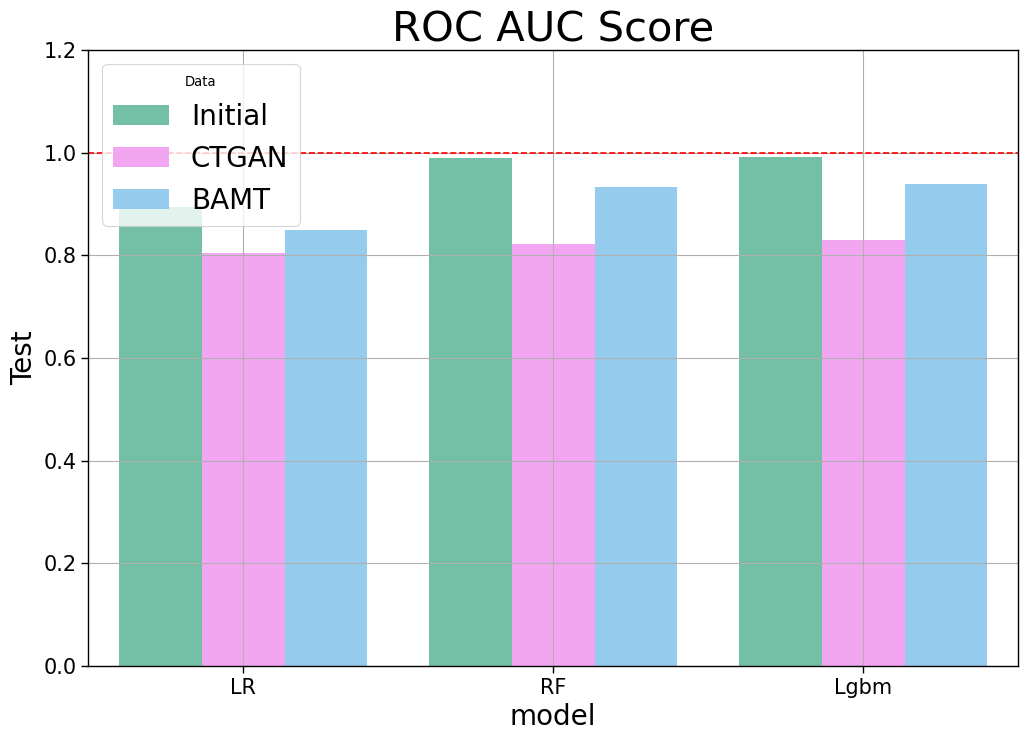

In [166]:
df=pd.concat([df_lr, df_rf, df_lgbm])
df.index.rename('Data', inplace=True)
df.reset_index(inplace=True)

fig = plt.figure(figsize=(12,8))
sns.barplot(x = 'model', y = 'Test', hue = 'Data', data = df, palette=['#66CDAA', '#FF99FF', '#87CEFA'])
plt.plot([-0.5, 2.5], [1, 1], color="red", linestyle="--")
plt.title('ROC AUC Score')
plt.xlim([-0.5,2.5])
plt.ylim([0,1.2])
plt.grid()
plt.show()

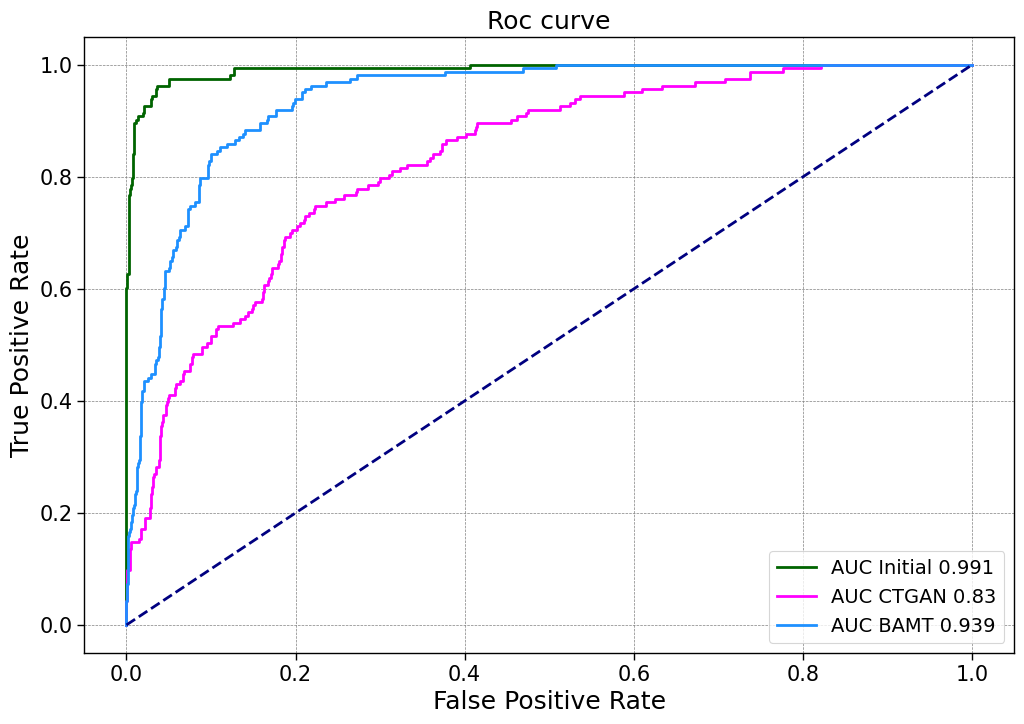

In [167]:
y_plot={'Initial': [y_test, y_pred_test_initial_lgbm],
        'CTGAN': [y_test, y_pred_test_ctgan_lgbm],
        'BAMT': [y_test, y_pred_test_bamt_lgbm]}
plot_roc_curve(y_plot)

# Загрузка данных для задачи регрессии

In [168]:
data = pd.read_csv('./data/California_airbnb.csv')
data.drop(columns=['Date', 'id', 'scrape_id', 'calendar_last_scraped', 'name',
                   'host_id', 'host_since', 'latitude', 'longitude', 'first_review',
                   'last_review', 'amenities', 'Country', 'Zone', 'host_city', 'host_country', 'room_type', 'bathrooms_text'], inplace=True)
data.head()

host_response_time  host_response_rate  host_acceptance_rate  \
0                NaN                 NaN                  50.0   
1                NaN                 NaN                 100.0   
2     within an hour               100.0                  42.0   
3                NaN                 NaN                   NaN   
4     within an hour               100.0                  96.0   

   host_is_superhost  host_listings_count  host_total_listings_count  \
0                0.0                  1.0                        3.0   
1                1.0                  2.0                        3.0   
2                0.0                  2.0                        2.0   
3                0.0                  1.0                        1.0   
4                1.0                  3.0                        4.0   

   host_has_profile_pic  host_identity_verified neighbourhood_cleansed  \
0                   1.0                     1.0            Culver City   
1                   1.0                     1.0              Hollywood   
2                   1.0                     1.0           Santa Monica   
3                   1.0                     1.0             Bellflower   
4                   1.0                     1.0        Hollywood Hills   

                 property_type  ...  review_scores_location  \
0                 Entire condo  ...                    5.00   
1  Private room in rental unit  ...                    4.95   
2  Private room in rental unit  ...                    4.91   
3           Entire rental unit  ...                     NaN   
4         Private room in home  ...                    4.97   

   review_scores_value  instant_bookable  calculated_host_listings_count  \
0                 4.00                 0                               1   
1                 4.88                 1                               2   
2                 4.22                 0                               2   
3                  NaN                 0                               1   
4                 4.90                 0                               3   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            0   
2                                            1   
3                                            1   
4                                            1   

   calculated_host_listings_count_private_rooms  \
0                                             0   
1                                             2   
2                                             1   
3                                             0   
4                                             2   

   calculated_host_listings_count_shared_rooms  reviews_per_month  bedrooms  \
0                                            0               0.01       2.0   
1                                            0               0.35       1.0   
2                                            0               0.16       2.0   
3                                            0                NaN       NaN   
4                                            0               1.02       NaN   

          City  
0  los-angeles  
1  los-angeles  
2  los-angeles  
3  los-angeles  
4  los-angeles  

[5 rows x 44 columns]

In [169]:
data.shape

(247859, 44)

In [170]:
data.isna().mean()

host_response_time                              0.185884
host_response_rate                              0.185884
host_acceptance_rate                            0.159635
host_is_superhost                               0.087723
host_listings_count                             0.000121
host_total_listings_count                       0.000121
host_has_profile_pic                            0.000121
host_identity_verified                          0.000121
neighbourhood_cleansed                          0.000000
property_type                                   0.000000
accommodates                                    0.000000
beds                                            0.018043
price                                           0.010926
minimum_nights                                  0.000000
maximum_nights                                  0.000000
minimum_minimum_nights                          0.000024
maximum_minimum_nights                          0.000024
minimum_maximum_nights         

In [171]:
for col in data.columns:
    if data[col].isna().mean() >= 0.8:
        print(col)
        data.drop([col], axis=1, inplace=True)

In [172]:
data.dtypes.value_counts()

float64    25
int64      15
object      4
dtype: int64

In [173]:
for col in data.isna().mean()[data.isna().mean() > 0].index:
    if data[col].dtype == 'object':
        data[col].fillna('Unknown', inplace=True)
    else:
        m = data[col].mode()[0]
        data[col].fillna(m, inplace=True)

In [174]:
bin_float_cols = [col for col in data if data[col].nunique() == 2 and data[col].dtype == 'float']

disc_float_cols = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'beds',
'price', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'bedrooms']

data[bin_float_cols + disc_float_cols] = data[bin_float_cols + disc_float_cols].astype(int)
data.price = data.price.astype(float)

In [175]:
cat_features = list(data.loc[:, data.dtypes == object].columns)
print(cat_features)

for col in cat_features:
      if data[col].nunique() > 10:
        print(col, '-', data[col].nunique())

['host_response_time', 'neighbourhood_cleansed', 'property_type', 'City']
neighbourhood_cleansed - 558
property_type - 125


In [176]:
data_1 = data.copy()

In [177]:
data_1 = data_1[data_1.neighbourhood_cleansed.isin(data_1.neighbourhood_cleansed.value_counts()[:7].index.to_list())]
data_1 = data_1[data_1.property_type.isin(data_1.property_type.value_counts()[:7].index.to_list())]
data_1.shape

(32014, 44)

In [178]:
data.select_dtypes('object').columns

Index(['host_response_time', 'neighbourhood_cleansed', 'property_type',
       'City'],
      dtype='object')

In [179]:
data.select_dtypes('float').columns

Index(['price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [180]:
data.select_dtypes('int').columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'instant_bookable', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'bedrooms'],
      dtype='object')

In [181]:
for col in data.select_dtypes('object').columns:
    print(data_1[col].value_counts(dropna=False))

within an hour        20761
Unknown                5863
within a few hours     3417
within a day           1549
a few days or more      424
Name: host_response_time, dtype: int64
San Jose                7181
Mission Bay             4594
Hollywood               4291
Long Beach              4120
Venice                  4087
Beverly Hills           3879
Unincorporated Areas    3862
Name: neighbourhood_cleansed, dtype: int64
Entire rental unit             10793
Entire home                     9597
Private room in home            4443
Entire condo                    3000
Entire guesthouse               1780
Private room in rental unit     1367
Entire guest suite              1034
Name: property_type, dtype: int64
los-angeles           16377
santa-clara-county     7946
san-diego              4594
santa-cruz-county      2071
san-mateo-county       1026
Name: City, dtype: int64


In [182]:
f_list = [data_1.select_dtypes(exclude=['int', 'float']),
          data_1[['price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                 'review_scores_location', 'review_scores_communication', 'reviews_per_month']],
          data_1[['bedrooms', 'accommodates', 'beds', 'host_acceptance_rate', 'host_is_superhost', 'number_of_reviews']]]

data_1 = pd.concat(f_list, axis=1)

data_1 = data_1.sample(30000, random_state=42).reset_index(drop=True)
data_1.shape

(30000, 17)

In [183]:
data_1.columns

Index(['host_response_time', 'neighbourhood_cleansed', 'property_type', 'City',
       'price', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_location',
       'review_scores_communication', 'reviews_per_month', 'bedrooms',
       'accommodates', 'beds', 'host_acceptance_rate', 'host_is_superhost',
       'number_of_reviews'],
      dtype='object')

In [184]:
for col in cat_features:
    print(col, '-', data_1[col].nunique())

host_response_time - 5
neighbourhood_cleansed - 7
property_type - 7
City - 5


In [185]:
data_1.dtypes.value_counts()

float64    7
int64      6
object     4
dtype: int64

In [186]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_1.drop(['price'], axis=1),
                                                    data_1['price'], test_size=0.1,
                                                    shuffle=True,
                                                    random_state=42)

In [187]:
X_train.shape, X_test.shape

((27000, 16), (3000, 16))

In [188]:
real_data = X_train.copy()
real_data['price'] = y_train

# Генерация синтетических данных при помощи CTGAN для задачи регрессии

In [189]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data_1)
python_dict = metadata.to_dict()

INFO:sdv.metadata.single_table:Detected metadata:
INFO:sdv.metadata.single_table:{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "host_response_time": {
            "sdtype": "categorical"
        },
        "neighbourhood_cleansed": {
            "sdtype": "categorical"
        },
        "property_type": {
            "sdtype": "categorical"
        },
        "City": {
            "sdtype": "city",
            "pii": true
        },
        "price": {
            "sdtype": "numerical"
        },
        "review_scores_rating": {
            "sdtype": "numerical"
        },
        "review_scores_accuracy": {
            "sdtype": "numerical"
        },
        "review_scores_cleanliness": {
            "sdtype": "numerical"
        },
        "review_scores_location": {
            "sdtype": "numerical"
        },
        "review_scores_communication": {
            "sdtype": "numerical"
        },
        "reviews_per_month": {
            "sdtype": "nume

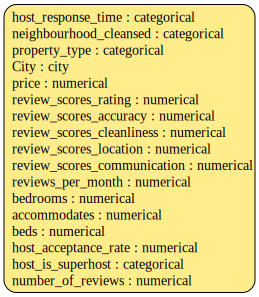

In [190]:
metadata.visualize()

In [191]:
metadata.update_columns_metadata(
    column_metadata={
        'City': {'sdtype': 'categorical'},
    },
)

In [192]:
metadata.save_to_json('./data/metadata_reg.json')

INFO:SingleTableMetadata:
Metadata Save:
  Timestamp: 2024-10-28 12:46:31.124386
  Statistics about the metadata:
    Total number of tables: 1    Total number of columns: 17    Total number of relationships: 0


In [193]:
%%time
ctgan_model_reg = CTGANSynthesizer(
    metadata,
    enforce_rounding=True,
    epochs=50,
    verbose=True,
    enforce_min_max_values=True
)
ctgan_model_reg.fit(real_data)

synthetic_data = ctgan_model_reg.sample(num_rows=real_data.shape[0])
synthetic_data.head()

INFO:SingleTableSynthesizer:{'EVENT': 'Instance', 'TIMESTAMP': datetime.datetime(2024, 10, 28, 12, 46, 33, 613844), 'SYNTHESIZER CLASS NAME': 'CTGANSynthesizer', 'SYNTHESIZER ID': 'CTGANSynthesizer_1.16.1_f02b883c16e042e49c8de4b84d5e6937'}
INFO:SingleTableSynthesizer:{'EVENT': 'Fit', 'TIMESTAMP': datetime.datetime(2024, 10, 28, 12, 46, 33, 616620), 'SYNTHESIZER CLASS NAME': 'CTGANSynthesizer', 'SYNTHESIZER ID': 'CTGANSynthesizer_1.16.1_f02b883c16e042e49c8de4b84d5e6937', 'TOTAL NUMBER OF TABLES': 1, 'TOTAL NUMBER OF ROWS': 27000, 'TOTAL NUMBER OF COLUMNS': 17}
INFO:sdv.data_processing.data_processor:Fitting table  metadata
INFO:sdv.data_processing.data_processor:Fitting formatters for table 
INFO:sdv.data_processing.data_processor:Fitting constraints for table 
INFO:sdv.data_processing.data_processor:Setting the configuration for the ``HyperTransformer`` for table 
INFO:sdv.data_processing.data_processor:Fitting HyperTransformer for table 
INFO:SingleTableSynthesizer:{'EVENT': 'Fit proc

CPU times: user 11min 14s, sys: 8min 42s, total: 19min 57s
Wall time: 3min 21s


host_response_time neighbourhood_cleansed                property_type  \
0  within a few hours            Mission Bay                  Entire home   
1             Unknown          Beverly Hills  Private room in rental unit   
2      within an hour              Hollywood         Private room in home   
3      within an hour            Mission Bay                  Entire home   
4             Unknown               San Jose         Private room in home   

                 City  price  review_scores_rating  review_scores_accuracy  \
0           san-diego  346.0                  4.65                    5.00   
1         los-angeles  130.0                  4.60                    4.82   
2         los-angeles   22.0                  4.82                    4.80   
3           san-diego  302.0                  4.84                    4.92   
4  santa-clara-county  136.0                  5.00                    5.00   

   review_scores_cleanliness  review_scores_location  \
0                       4.89                    5.00   
1                       4.40                    4.79   
2                       4.62                    4.84   
3                       4.55                    4.85   
4                       4.33                    4.99   

   review_scores_communication  reviews_per_month  bedrooms  accommodates  \
0                         5.00               0.01         1             6   
1                         4.93               0.21         1             3   
2                         4.60               0.48         1             2   
3                         4.78               0.36         1            12   
4                         5.00               0.99         1             2   

   beds  host_acceptance_rate  host_is_superhost  number_of_reviews  
0     3                    97                  1                 38  
1     1                    97                  0                 16  
2     1                    63                  1                 11  
3     4                    76                  1                 98  
4     1                   100                  1                  3

In [194]:
synthetic_data.shape

(27000, 17)

In [195]:
synthetic_data.to_csv('./synthetic data/synthetic_data_CTGAN_reg_test.csv', index=False)

# Генерация синтетических данных при помощи Байесовских сетей для задачи регрессии

In [196]:
label_encoders = {}
real_data_enc = real_data.copy()

for column in real_data_enc.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    real_data_enc[column] = le.fit_transform(real_data_enc[column])
    label_encoders[column] = le

real_data_enc = real_data_enc.dropna()
real_data_enc

host_response_time  neighbourhood_cleansed  property_type  City  \
346                     0                       1              6     0   
13028                   4                       0              4     0   
8821                    4                       5              0     4   
25676                   4                       3              0     1   
7534                    4                       2              5     0   
...                   ...                     ...            ...   ...   
29802                   3                       6              3     0   
5390                    4                       5              2     3   
860                     0                       5              3     3   
15795                   0                       4              5     3   
23654                   4                       2              4     0   

       review_scores_rating  review_scores_accuracy  \
346                    5.00                    5.00   
13028                  5.00                    5.00   
8821                   4.49                    4.49   
25676                  4.63                    4.70   
7534                   5.00                    0.00   
...                     ...                     ...   
29802                  5.00                    5.00   
5390                   5.00                    5.00   
860                    5.00                    5.00   
15795                  5.00                    5.00   
23654                  5.00                    5.00   

       review_scores_cleanliness  review_scores_location  \
346                         5.00                    5.00   
13028                       5.00                    5.00   
8821                        4.28                    4.80   
25676                       4.80                    4.89   
7534                        0.00                    0.00   
...                          ...                     ...   
29802                       5.00                    5.00   
5390                        5.00                    5.00   
860                         5.00                    5.00   
15795                       5.00                    5.00   
23654                       5.00                    5.00   

       review_scores_communication  reviews_per_month  bedrooms  accommodates  \
346                           5.00               1.00         1             1   
13028                         5.00               1.00         1             2   
8821                          4.81               0.78         2            10   
25676                         4.29               1.57         1             3   
7534                          0.00               0.01         2             6   
...                            ...                ...       ...           ...   
29802                         5.00               0.40         1             6   
5390                          5.00               3.10         3             2   
860                           5.00               1.00         1             2   
15795                         5.00               1.00         1             6   
23654                         5.00               1.00         1             4   

       beds  host_acceptance_rate  host_is_superhost  number_of_reviews  price  
346       1                   100                  0                  0   80.0  
13028     1                   100                  0                  0  150.0  
8821      6                    99                  0                 80  756.0  
25676     2                   100                  0                 56  143.0  
7534      3                   100                  0                  1  125.0  
...     ...                   ...                ...                ...    ...  
29802     2                    67                  1                  2  420.0  
5390      1                    91                  0                  6  141.0  
860       1                     0 

In [197]:
cleaned_real_data = remove_outliers(real_data_enc)

print(f"Размер данных до очистки: {real_data_enc.shape}")
print(f"Размер данных после очистки: {cleaned_real_data.shape}")

Index(['host_response_time', 'neighbourhood_cleansed', 'property_type', 'City',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_location',
       'review_scores_communication', 'reviews_per_month', 'bedrooms',
       'accommodates', 'beds', 'host_acceptance_rate', 'host_is_superhost',
       'number_of_reviews', 'price'],
      dtype='object')
Размер данных до очистки: (27000, 17)
Размер данных после очистки: (7958, 17)


In [198]:
from sklearn.preprocessing import KBinsDiscretizer

# Выбираем непрерывные переменные
continuous_columns = cleaned_real_data.select_dtypes(include=['float64', 'int64']).columns
# Дискретизация с использованием равных интервалов (по умолчанию — 5 интервалов)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
# Применяем дискретизацию к непрерывным переменным
cleaned_real_data[continuous_columns] = discretizer.fit_transform(cleaned_real_data[continuous_columns])

In [199]:
cleaned_real_data

host_response_time  neighbourhood_cleansed  property_type  City  \
13028                 4.0                     0.0            3.0   0.0   
23389                 4.0                     3.0            4.0   3.0   
10504                 4.0                     0.0            3.0   0.0   
7301                  4.0                     4.0            1.0   0.0   
3050                  4.0                     2.0            1.0   1.0   
...                   ...                     ...            ...   ...   
14423                 4.0                     0.0            0.0   0.0   
16850                 4.0                     3.0            4.0   3.0   
6265                  4.0                     3.0            4.0   3.0   
5390                  4.0                     4.0            0.0   3.0   
23654                 4.0                     1.0            3.0   0.0   

       review_scores_rating  review_scores_accuracy  \
13028                   4.0                     4.0   
23389                   4.0                     2.0   
10504                   4.0                     4.0   
7301                    4.0                     4.0   
3050                    4.0                     3.0   
...                     ...                     ...   
14423                   4.0                     4.0   
16850                   3.0                     4.0   
6265                    4.0                     3.0   
5390                    4.0                     4.0   
23654                   4.0                     4.0   

       review_scores_cleanliness  review_scores_location  \
13028                        4.0                     4.0   
23389                        4.0                     4.0   
10504                        3.0                     4.0   
7301                         4.0                     4.0   
3050                         4.0                     3.0   
...                          ...                     ...   
14423                        4.0                     4.0   
16850                        4.0                     1.0   
6265                         4.0                     0.0   
5390                         4.0                     4.0   
23654                        4.0                     4.0   

       review_scores_communication  reviews_per_month  bedrooms  accommodates  \
13028                          4.0                1.0       1.0           0.0   
23389                          2.0                0.0       1.0           0.0   
10504                          4.0                3.0       1.0           1.0   
7301                           4.0                0.0       4.0           2.0   
3050                           4.0                2.0       3.0           2.0   
...                            ...                ...       ...           ...   
14423                          4.0                0.0       1.0           0.0   
16850                          4.0                0.0       1.0           0.0   
6265                           3.0                2.0       1.0           0.0   
5390                           4.0                4.0       4.0           0.0   
23654                          4.0                1.0       1.0           1.0   

       beds  host_acceptance_rate  host_is_superhost  number_of_reviews  price  
13028   0.0                   4.0                0.0                0.0    1.0  
23389   0.0                   4.0                4.0                0.0    0.0  
10504   1.0                   3.0                4.0                0.0    1.0  
7301    2.0                   4.0                4.0                0.0    4.0  
3050    3.0                   4.0                4.0                1.0    2.0  
...     ...                   ...                ...                ...    ...  
14423   0.0                   4.0                0.0                0.0    0.0  
16850   0.0                   4.0                0.0                0.0    0.0  
6265    0.0                   4.0 

In [200]:
hc = HillClimbSearch(cleaned_real_data)
# best_model = hc.estimate(scoring_method=BicScore(real_data))
best_model = hc.estimate(scoring_method=BDsScore(cleaned_real_data)) #  K2Score

model = BayesianNetwork(best_model.edges())
model.fit(real_data_enc, estimator=MaximumLikelihoodEstimator)


  0%|          | 30/1000000 [00:01<14:42:07, 18.89it/s]


In [202]:
#Генерация новых синтетических данных
sampler = BayesianModelSampling(model)

synthetic_samples = sampler.forward_sample(size=real_data_enc.shape[0])

synthetic_samples_df = pd.DataFrame(synthetic_samples)

synthetic_samples_df


Generating for node: review_scores_cleanliness:  88%|████████▊ | 15/17 [00:01<00:00,  6.90it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
Generating for node: review_scores_communication:  94%|█████████▍| 16/17 [00:01<00:00,  6.18it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
Generating for node: review_scores_communication: 100%|██████████| 17/17 [00:02<00:00,  7.54it/s]


neighbourhood_cleansed  reviews_per_month  host_acceptance_rate  \
0                           5               1.21                    99   
1                           3               1.00                    98   
2                           3               0.39                    96   
3                           1               1.00                   100   
4                           5               2.17                   100   
...                       ...                ...                   ...   
26995                       4               0.38                   100   
26996                       4               0.20                    88   
26997                       4               3.53                    93   
26998                       4               0.38                   100   
26999                       4               1.00                     0   

       number_of_reviews  property_type  City  beds  bedrooms  \
0                     97              0     4     5         1   
1                      0              3     1     3         4   
2                     44              4     1     1         2   
3                      0              6     0     1         1   
4                     29              3     2     8         2   
...                  ...            ...   ...   ...       ...   
26995                 26              5     3     1         1   
26996                  2              3     3     1         1   
26997                 87              5     3     2         1   
26998                  1              5     3     1         3   
26999                  1              6     3     1         1   

       review_scores_rating  review_scores_cleanliness  \
0                      4.52                       4.39   
1                      5.00                       5.00   
2                      4.95                       4.89   
3                      5.00                       5.00   
4                      4.90                       4.90   
...                     ...                        ...   
26995                  4.77                       4.95   
26996                  5.00                       5.00   
26997                  4.82                       4.74   
26998                  5.00                       5.00   
26999                  5.00                       5.00   

       review_scores_communication  review_scores_accuracy  \
0                             4.88                    4.82   
1                             5.00                    5.00   
2                             4.98                    5.00   
3                             5.00                    5.00   
4                             4.87                    4.97   
...                            ...                     ...   
26995                         4.65                    4.73   
26996                         5.00                    5.00   
26997                         4.90                    4.78   
26998                         5.00                    5.00   
26999                         5.00                    5.00   

       review_scores_location  host_is_superhost  accommodates  price  \
0                        4.96                  1            10  331.0   
1                        5.00                  0             7  679.0   
2                        4.86                  0             4   99.0   
3                        5.00                  0             2   81.0   
4                        4.96                  0            11  291.0   
...                       ...                ...           ...    ...   
26995                    4.81                  0             2   60.0   
26996                    5.00                  0             4  139.0   
26997                    4.84                  1             4   70.0   
26998                    5.00                  0             2   50.0   
26999                    5.00                  0             1   80.0   

       host_respon

In [203]:
synthetic_samples_df.shape

(27000, 17)

In [204]:
cleared_synthetic_samples_df = remove_outliers(synthetic_samples_df)
cleared_synthetic_samples_df.shape

Index(['neighbourhood_cleansed', 'reviews_per_month', 'host_acceptance_rate',
       'number_of_reviews', 'property_type', 'City', 'beds', 'bedrooms',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_accuracy',
       'review_scores_location', 'host_is_superhost', 'accommodates', 'price',
       'host_response_time'],
      dtype='object')


(12657, 17)

In [205]:
# Декодируем обратно категориальные переменные
for column, le in label_encoders.items():
    synthetic_samples_df[column] = le.inverse_transform(synthetic_samples_df[column])

synthetic_samples_df

neighbourhood_cleansed  reviews_per_month  host_acceptance_rate  \
0       Unincorporated Areas               1.21                    99   
1                Mission Bay               1.00                    98   
2                Mission Bay               0.39                    96   
3                  Hollywood               1.00                   100   
4       Unincorporated Areas               2.17                   100   
...                      ...                ...                   ...   
26995               San Jose               0.38                   100   
26996               San Jose               0.20                    88   
26997               San Jose               3.53                    93   
26998               San Jose               0.38                   100   
26999               San Jose               1.00                     0   

       number_of_reviews                property_type                City  \
0                     97                 Entire condo   santa-cruz-county   
1                      0                  Entire home           san-diego   
2                     44           Entire rental unit           san-diego   
3                      0  Private room in rental unit         los-angeles   
4                     29                  Entire home    san-mateo-county   
...                  ...                          ...                 ...   
26995                 26         Private room in home  santa-clara-county   
26996                  2                  Entire home  santa-clara-county   
26997                 87         Private room in home  santa-clara-county   
26998                  1         Private room in home  santa-clara-county   
26999                  1  Private room in rental unit  santa-clara-county   

       beds  bedrooms  review_scores_rating  review_scores_cleanliness  \
0         5         1                  4.52                       4.39   
1         3         4                  5.00                       5.00   
2         1         2                  4.95                       4.89   
3         1         1                  5.00                       5.00   
4         8         2                  4.90                       4.90   
...     ...       ...                   ...                        ...   
26995     1         1                  4.77                       4.95   
26996     1         1                  5.00                       5.00   
26997     2         1                  4.82                       4.74   
26998     1         3                  5.00                       5.00   
26999     1         1                  5.00                       5.00   

       review_scores_communication  review_scores_accuracy  \
0                             4.88                    4.82   
1                             5.00                    5.00   
2                             4.98                    5.00   
3                             5.00                    5.00   
4                             4.87                    4.97   
...                            ...                     ...   
26995                         4.65                    4.73   
26996                         5.00                    5.00   
26997                         4.90                    4.78   
26998                         5.00                    5.00   
26999                         5.00                    5.00   

       review_scores_location  host_is_superhost  accommodates  price  \
0                        4.96                  1            10  331.0   
1                        5.00                  0             7  679.0   
2                        4.86                  0             4   99.0   
3                        5.00                  0             2   81.0   
4                        4.96                  0            11  291.0   
...                       ...                ...           ...    ...   
26995                    4.81                  0           

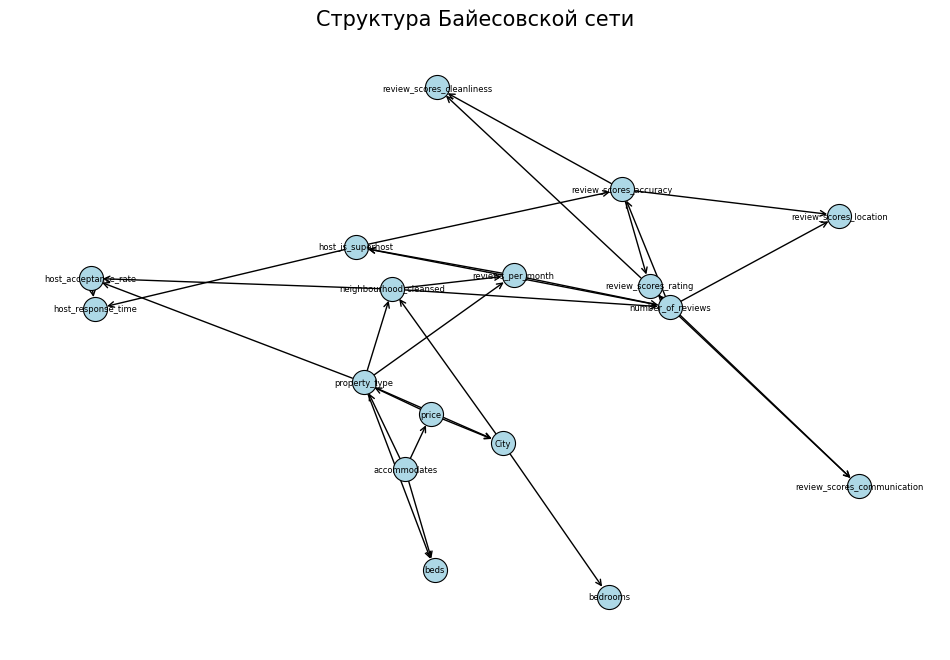

In [206]:
# Получаем структуру графа из модели
edges = best_model.edges()
G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', edgecolors='black')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10)
nx.draw_networkx_labels(G, pos, font_size=6, font_family='sans-serif')

plt.title("Структура Байесовской сети", fontsize=15)
plt.axis('off')
plt.show()

In [207]:
synthetic_samples_df.to_csv('./synthetic data/synthetic_data_BN_reg_test.csv', index=False)

 # Сравнение реальных и синтетических данных для задачи регрессии

In [208]:
import pandas as pd

synthetic_data_ctgan = pd.read_csv('./synthetic data/synthetic_data_CTGAN_reg_test.csv')
synthetic_data_bamt = pd.read_csv('./synthetic data/synthetic_data_BN_reg_test.csv')
metadata = SingleTableMetadata.load_from_json('./data/metadata_reg.json')

synthetic_data_ctgan.shape, synthetic_data_bamt.shape 

((27000, 17), (27000, 17))

In [209]:
synthetic_data_bamt.dtypes

neighbourhood_cleansed          object
reviews_per_month              float64
host_acceptance_rate             int64
number_of_reviews                int64
property_type                   object
City                            object
beds                             int64
bedrooms                         int64
review_scores_rating           float64
review_scores_cleanliness      float64
review_scores_communication    float64
review_scores_accuracy         float64
review_scores_location         float64
host_is_superhost                int64
accommodates                     int64
price                          float64
host_response_time              object
dtype: object

In [210]:
synthetic_data_ctgan.dtypes

host_response_time              object
neighbourhood_cleansed          object
property_type                   object
City                            object
price                          float64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_location         float64
review_scores_communication    float64
reviews_per_month              float64
bedrooms                         int64
accommodates                     int64
beds                             int64
host_acceptance_rate             int64
host_is_superhost                int64
number_of_reviews                int64
dtype: object

In [211]:
real_data.dtypes

host_response_time              object
neighbourhood_cleansed          object
property_type                   object
City                            object
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_location         float64
review_scores_communication    float64
reviews_per_month              float64
bedrooms                         int64
accommodates                     int64
beds                             int64
host_acceptance_rate             int64
host_is_superhost                int64
number_of_reviews                int64
price                          float64
dtype: object

In [212]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic_ctgan = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data_ctgan,
    metadata=metadata
)

diagnostic_bamt = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data_bamt,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 17/17 [00:00<00:00, 285.34it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 560.89it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 17/17 [00:00<00:00, 500.04it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 1096.55it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [213]:
diagnostic_ctgan.get_details(property_name='Data Validity')

Column             Metric  Score
0            host_response_time  CategoryAdherence    1.0
1        neighbourhood_cleansed  CategoryAdherence    1.0
2                 property_type  CategoryAdherence    1.0
3                          City  CategoryAdherence    1.0
4                         price  BoundaryAdherence    1.0
5          review_scores_rating  BoundaryAdherence    1.0
6        review_scores_accuracy  BoundaryAdherence    1.0
7     review_scores_cleanliness  BoundaryAdherence    1.0
8        review_scores_location  BoundaryAdherence    1.0
9   review_scores_communication  BoundaryAdherence    1.0
10            reviews_per_month  BoundaryAdherence    1.0
11                     bedrooms  BoundaryAdherence    1.0
12                 accommodates  BoundaryAdherence    1.0
13                         beds  BoundaryAdherence    1.0
14         host_acceptance_rate  BoundaryAdherence    1.0
15            host_is_superhost  CategoryAdherence    1.0
16            number_of_reviews  BoundaryAdherence    1.0

In [214]:
diagnostic_bamt.get_details(property_name='Data Validity')

Column             Metric  Score
0            host_response_time  CategoryAdherence    1.0
1        neighbourhood_cleansed  CategoryAdherence    1.0
2                 property_type  CategoryAdherence    1.0
3                          City  CategoryAdherence    1.0
4                         price  BoundaryAdherence    1.0
5          review_scores_rating  BoundaryAdherence    1.0
6        review_scores_accuracy  BoundaryAdherence    1.0
7     review_scores_cleanliness  BoundaryAdherence    1.0
8        review_scores_location  BoundaryAdherence    1.0
9   review_scores_communication  BoundaryAdherence    1.0
10            reviews_per_month  BoundaryAdherence    1.0
11                     bedrooms  BoundaryAdherence    1.0
12                 accommodates  BoundaryAdherence    1.0
13                         beds  BoundaryAdherence    1.0
14         host_acceptance_rate  BoundaryAdherence    1.0
15            host_is_superhost  CategoryAdherence    1.0
16            number_of_reviews  BoundaryAdherence    1.0

In [215]:
from sdv.evaluation.single_table import evaluate_quality

quality_report_ctgan = evaluate_quality(
    real_data=real_data,
    synthetic_data=synthetic_data_ctgan,
    metadata=metadata
)

quality_report_bamt = evaluate_quality(
    real_data=real_data,
    synthetic_data=synthetic_data_bamt,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 17/17 [00:00<00:00, 70.43it/s]|
Column Shapes Score: 90.53%

(2/2) Evaluating Column Pair Trends: |██████████| 136/136 [00:02<00:00, 46.09it/s]|
Column Pair Trends Score: 83.13%

Overall Score (Average): 86.83%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 17/17 [00:00<00:00, 76.72it/s]|
Column Shapes Score: 93.09%

(2/2) Evaluating Column Pair Trends: |██████████| 136/136 [00:02<00:00, 48.83it/s]|
Column Pair Trends Score: 89.53%

Overall Score (Average): 91.31%



In [216]:
ctgan_report = quality_report_ctgan.get_details('Column Shapes')
ctgan_report.rename(columns={'Score': 'CTGAN_score'}, inplace=True)

bamt_report = quality_report_bamt.get_details('Column Shapes')
bamt_report.rename(columns={'Score': 'BN_score'}, inplace=True)

adj_report = pd.concat([ctgan_report, bamt_report.BN_score], axis=1)
adj_report

Column        Metric  CTGAN_score  BN_score
0            host_response_time  TVComplement     0.779185  0.846481
1        neighbourhood_cleansed  TVComplement     0.893481  0.868667
2                 property_type  TVComplement     0.898148  0.724963
3                          City  TVComplement     0.916667  0.858741
4                         price  KSComplement     0.876630  0.818185
5          review_scores_rating  KSComplement     0.935074  0.984704
6        review_scores_accuracy  KSComplement     0.966333  0.987556
7     review_scores_cleanliness  KSComplement     0.934000  0.986778
8        review_scores_location  KSComplement     0.959296  0.980593
9   review_scores_communication  KSComplement     0.959111  0.979111
10            reviews_per_month  KSComplement     0.824407  0.977556
11                     bedrooms  KSComplement     0.920074  0.993148
12                 accommodates  KSComplement     0.952852  0.997593
13                         beds  KSComplement     0.984370  0.870889
14         host_acceptance_rate  KSComplement     0.878333  0.983444
15            host_is_superhost  TVComplement     0.881037  0.994593
16            number_of_reviews  KSComplement     0.830778  0.972889

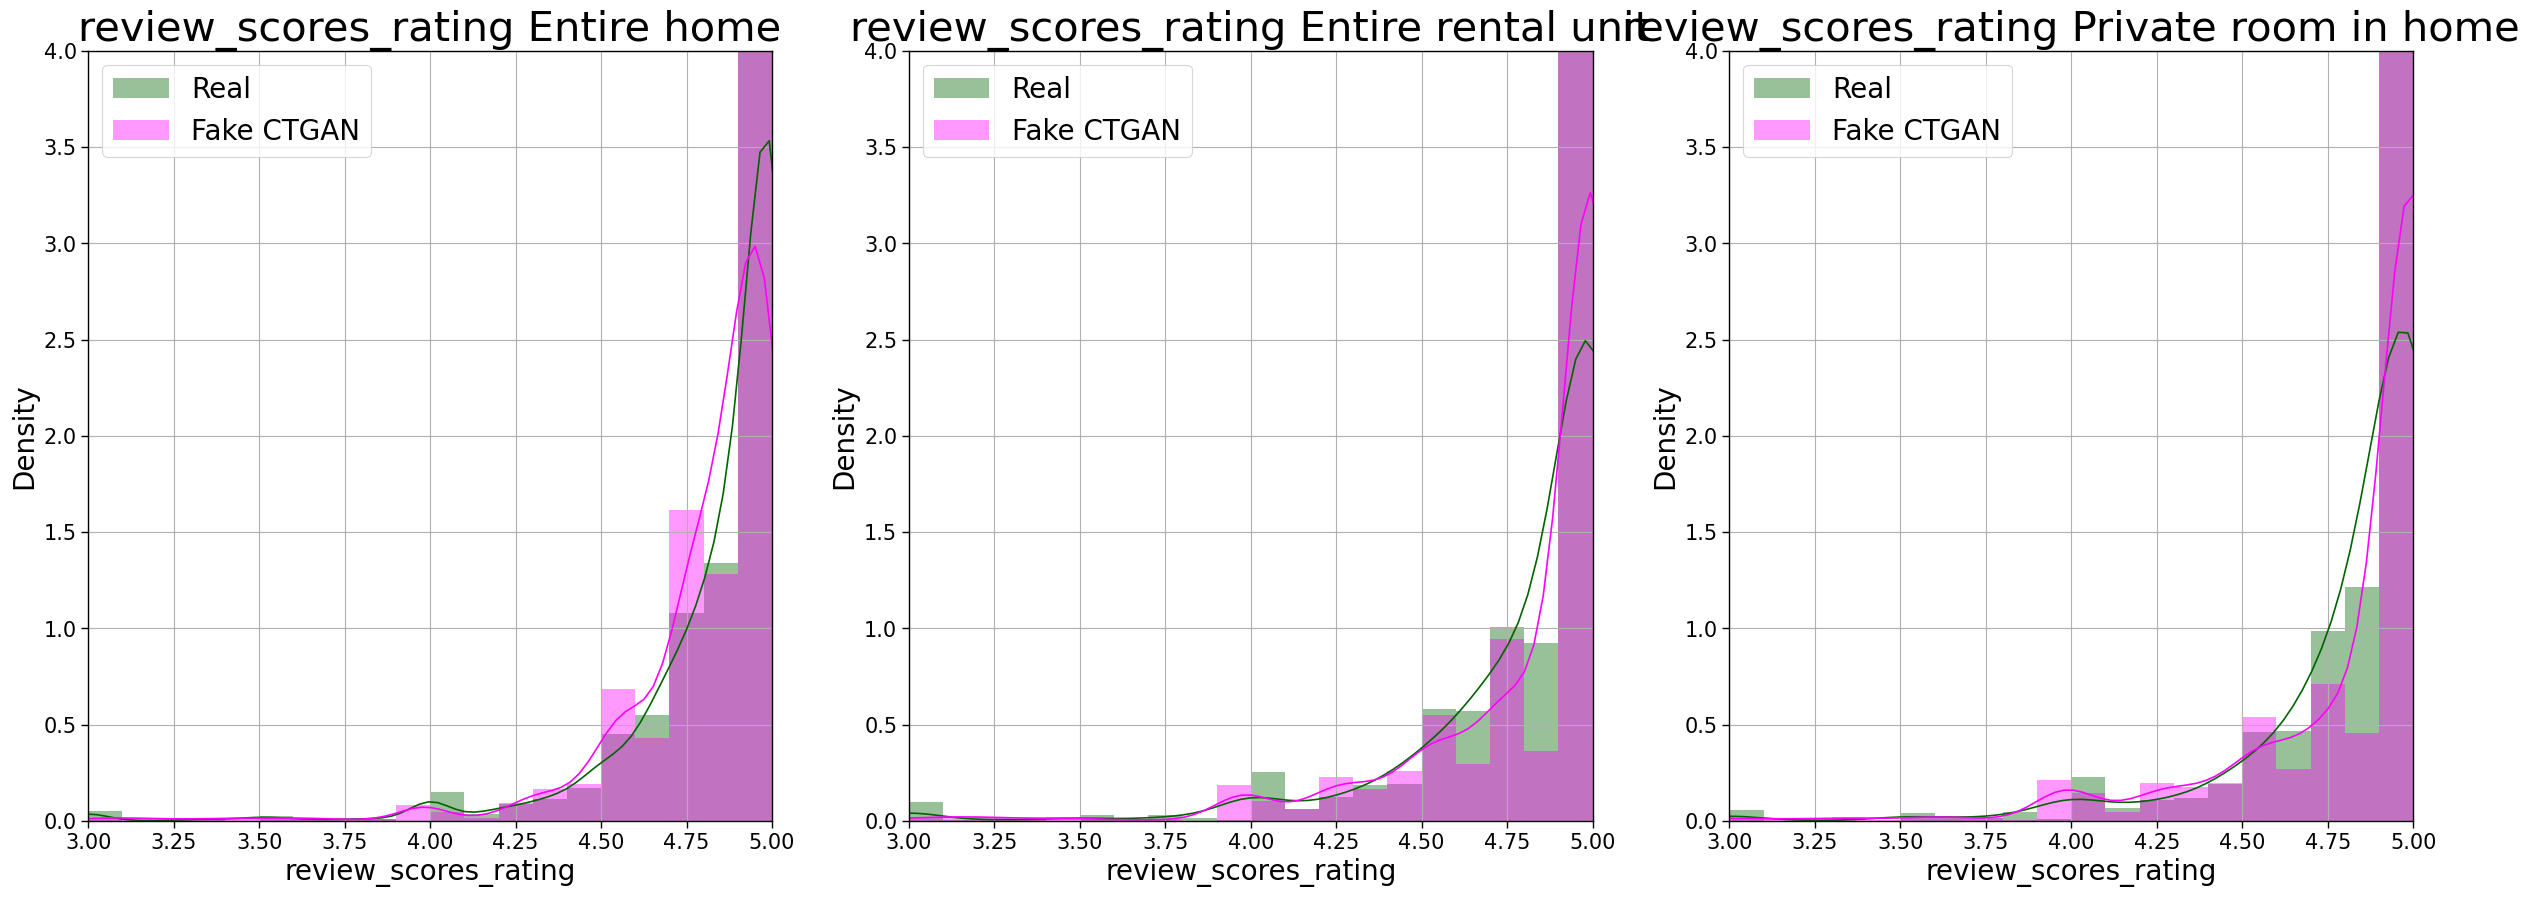

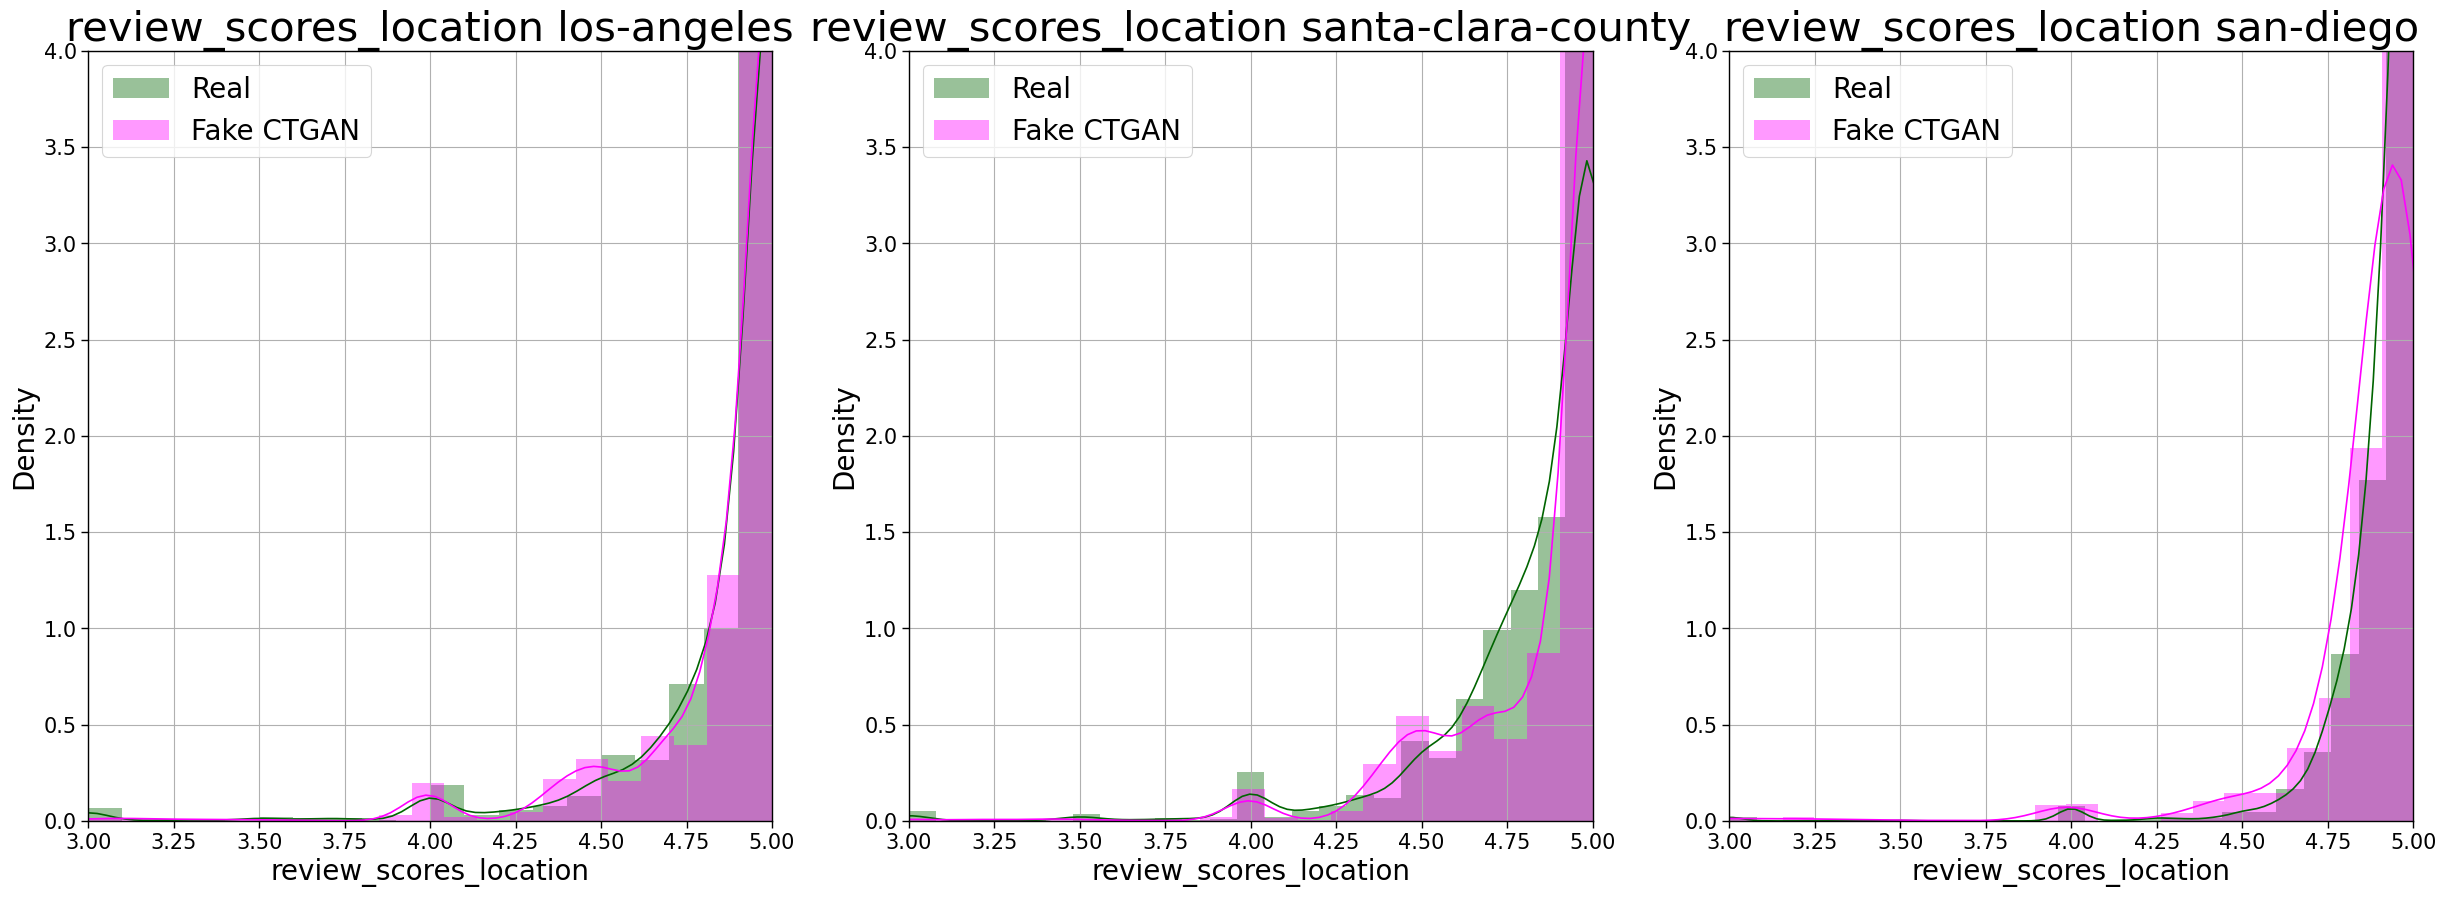

In [217]:
plot_cols = {'property_type': ['review_scores_rating'],
             'City': ['review_scores_location']}

sns.set_context("paper", rc={"axes.titlesize":30,"axes.labelsize":20, "legend.fontsize": 20, "xtick.labelsize":15, "ytick.labelsize":15})
for cat_name in plot_cols:
  cats = synthetic_data_ctgan[cat_name].value_counts().index[:3]
  for col in plot_cols[cat_name]:
    fig, ax= plt.subplots(1, len(cats), figsize=(10*len(cats), 10),)
    for i, cat in enumerate(cats):
      sns.distplot(X_train[X_train[cat_name]==cat][col], ax=ax[i], label='Real', color=REAL_COLOR)
      sns.distplot(synthetic_data_ctgan[synthetic_data_ctgan[cat_name]==cat][col], ax=ax[i], label='Fake CTGAN', color=CTGAN_COLOR)
      ax[i].grid(True)
      ax[i].set_title(f'{col} {cat}')
      ax[i].legend(loc=0)
      ax[i].set_ylim(0, 4)
      ax[i].set_xlim(3, 5)

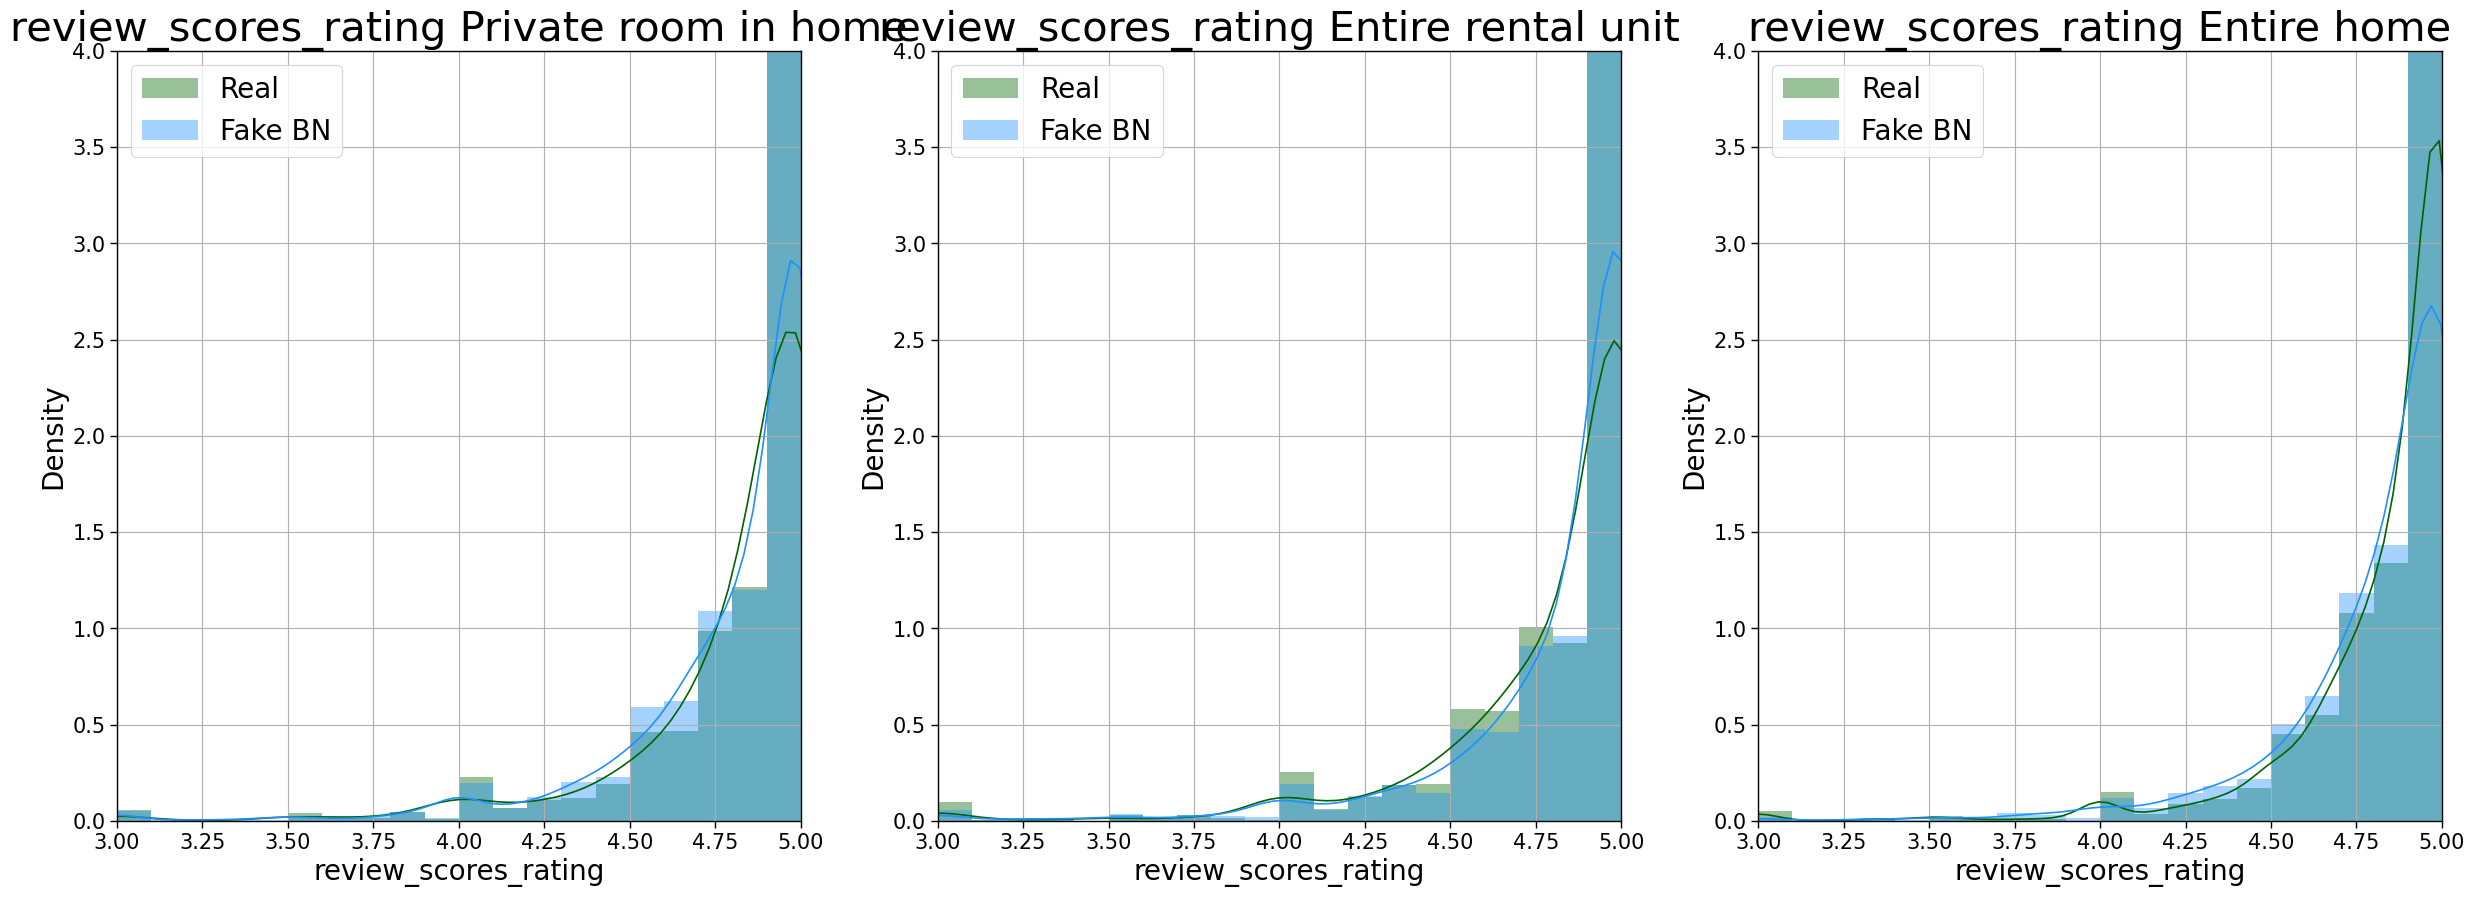

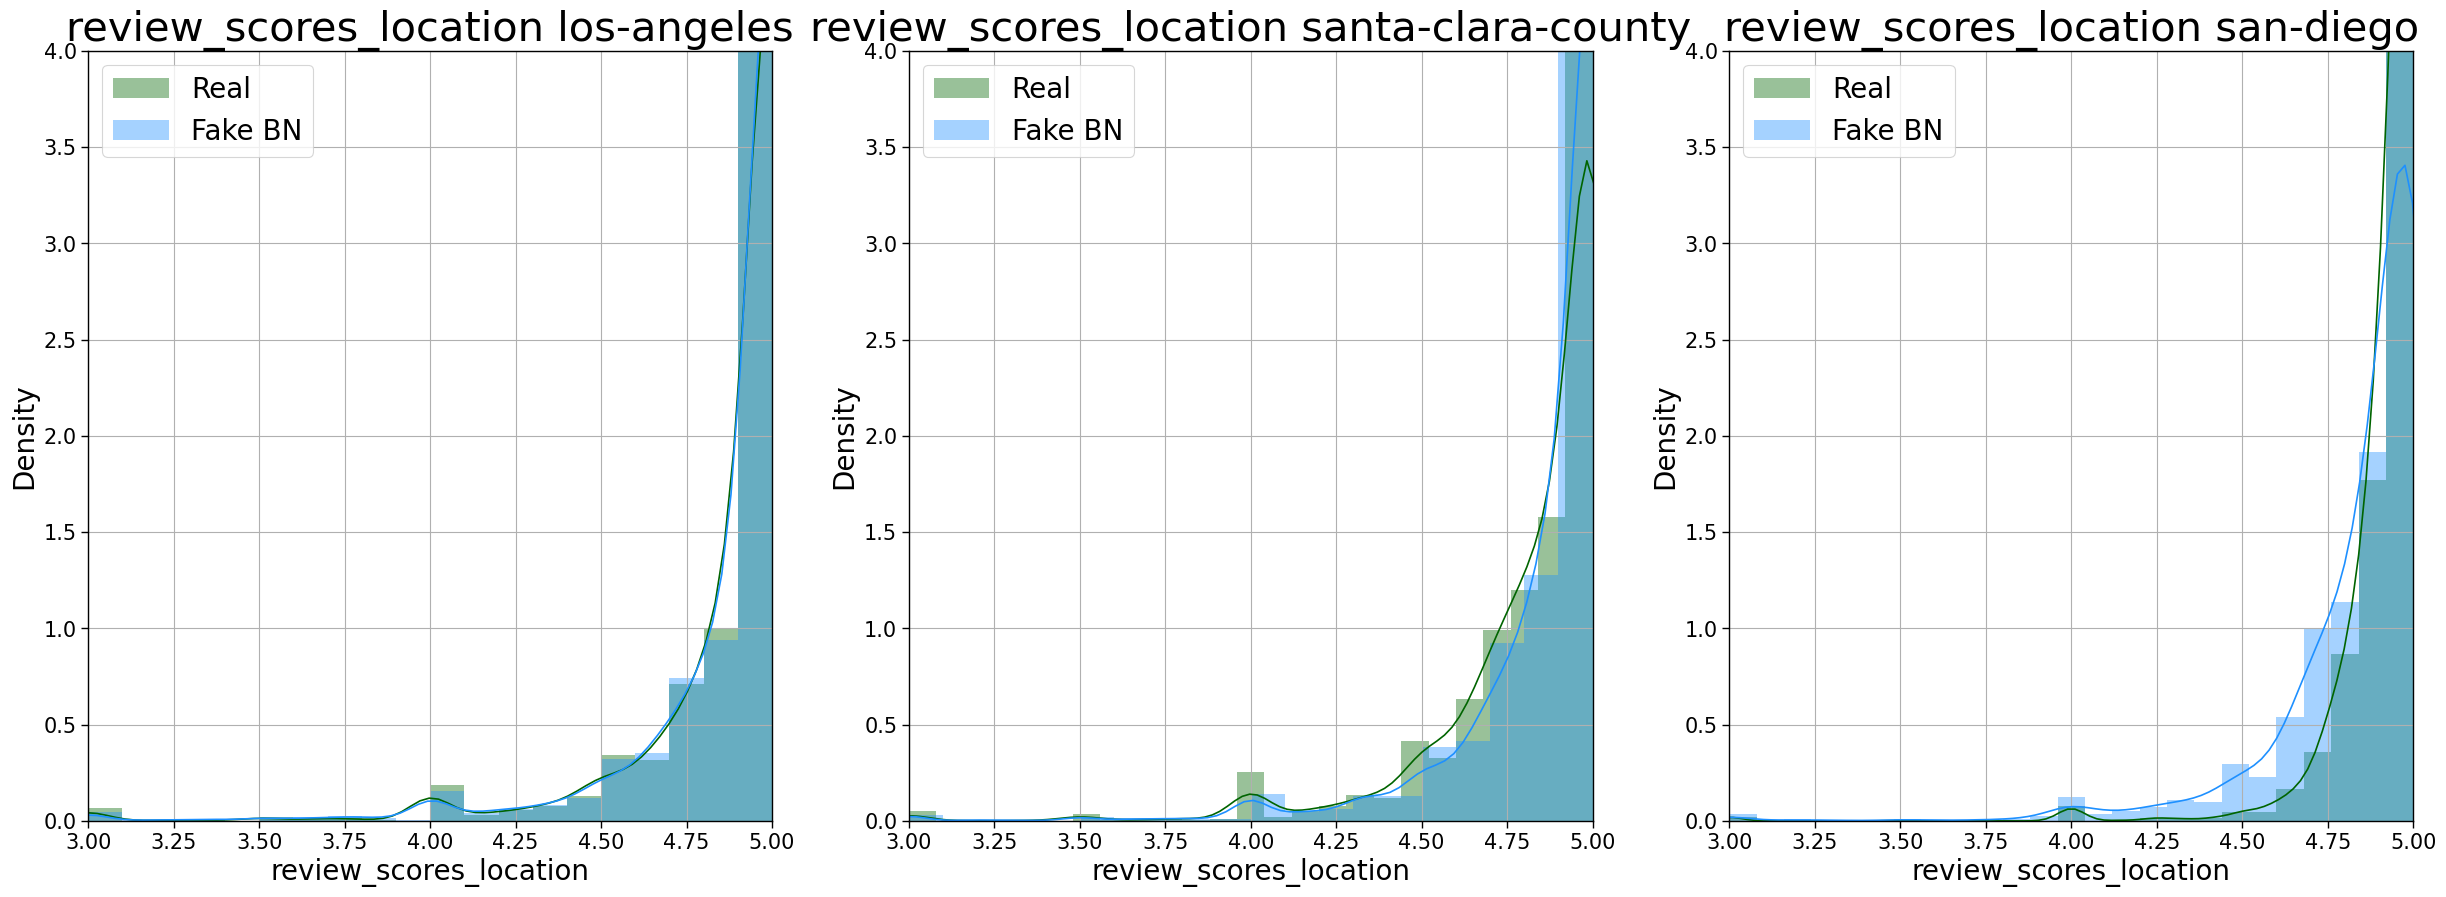

In [218]:
plot_cols = {'property_type': ['review_scores_rating'],
             'City': ['review_scores_location']}

sns.set_context("paper", rc={"axes.titlesize":30,"axes.labelsize":20, "legend.fontsize": 20, "xtick.labelsize":15, "ytick.labelsize":15})
for cat_name in plot_cols:
  cats = synthetic_data_bamt[cat_name].value_counts().index[:3]
  for col in plot_cols[cat_name]:
    fig, ax= plt.subplots(1, len(cats), figsize=(10*len(cats), 10),)
    for i, cat in enumerate(cats):
      sns.distplot(X_train[X_train[cat_name]==cat][col], ax=ax[i], label='Real', color=REAL_COLOR)
      sns.distplot(synthetic_data_bamt[synthetic_data_bamt[cat_name]==cat][col], ax=ax[i], label='Fake BN', color=BAMT_COLOR)
      ax[i].grid(True)
      ax[i].set_title(f'{col} {cat}')
      ax[i].legend(loc=0)
      ax[i].set_ylim(0, 4)
      ax[i].set_xlim(3, 5)

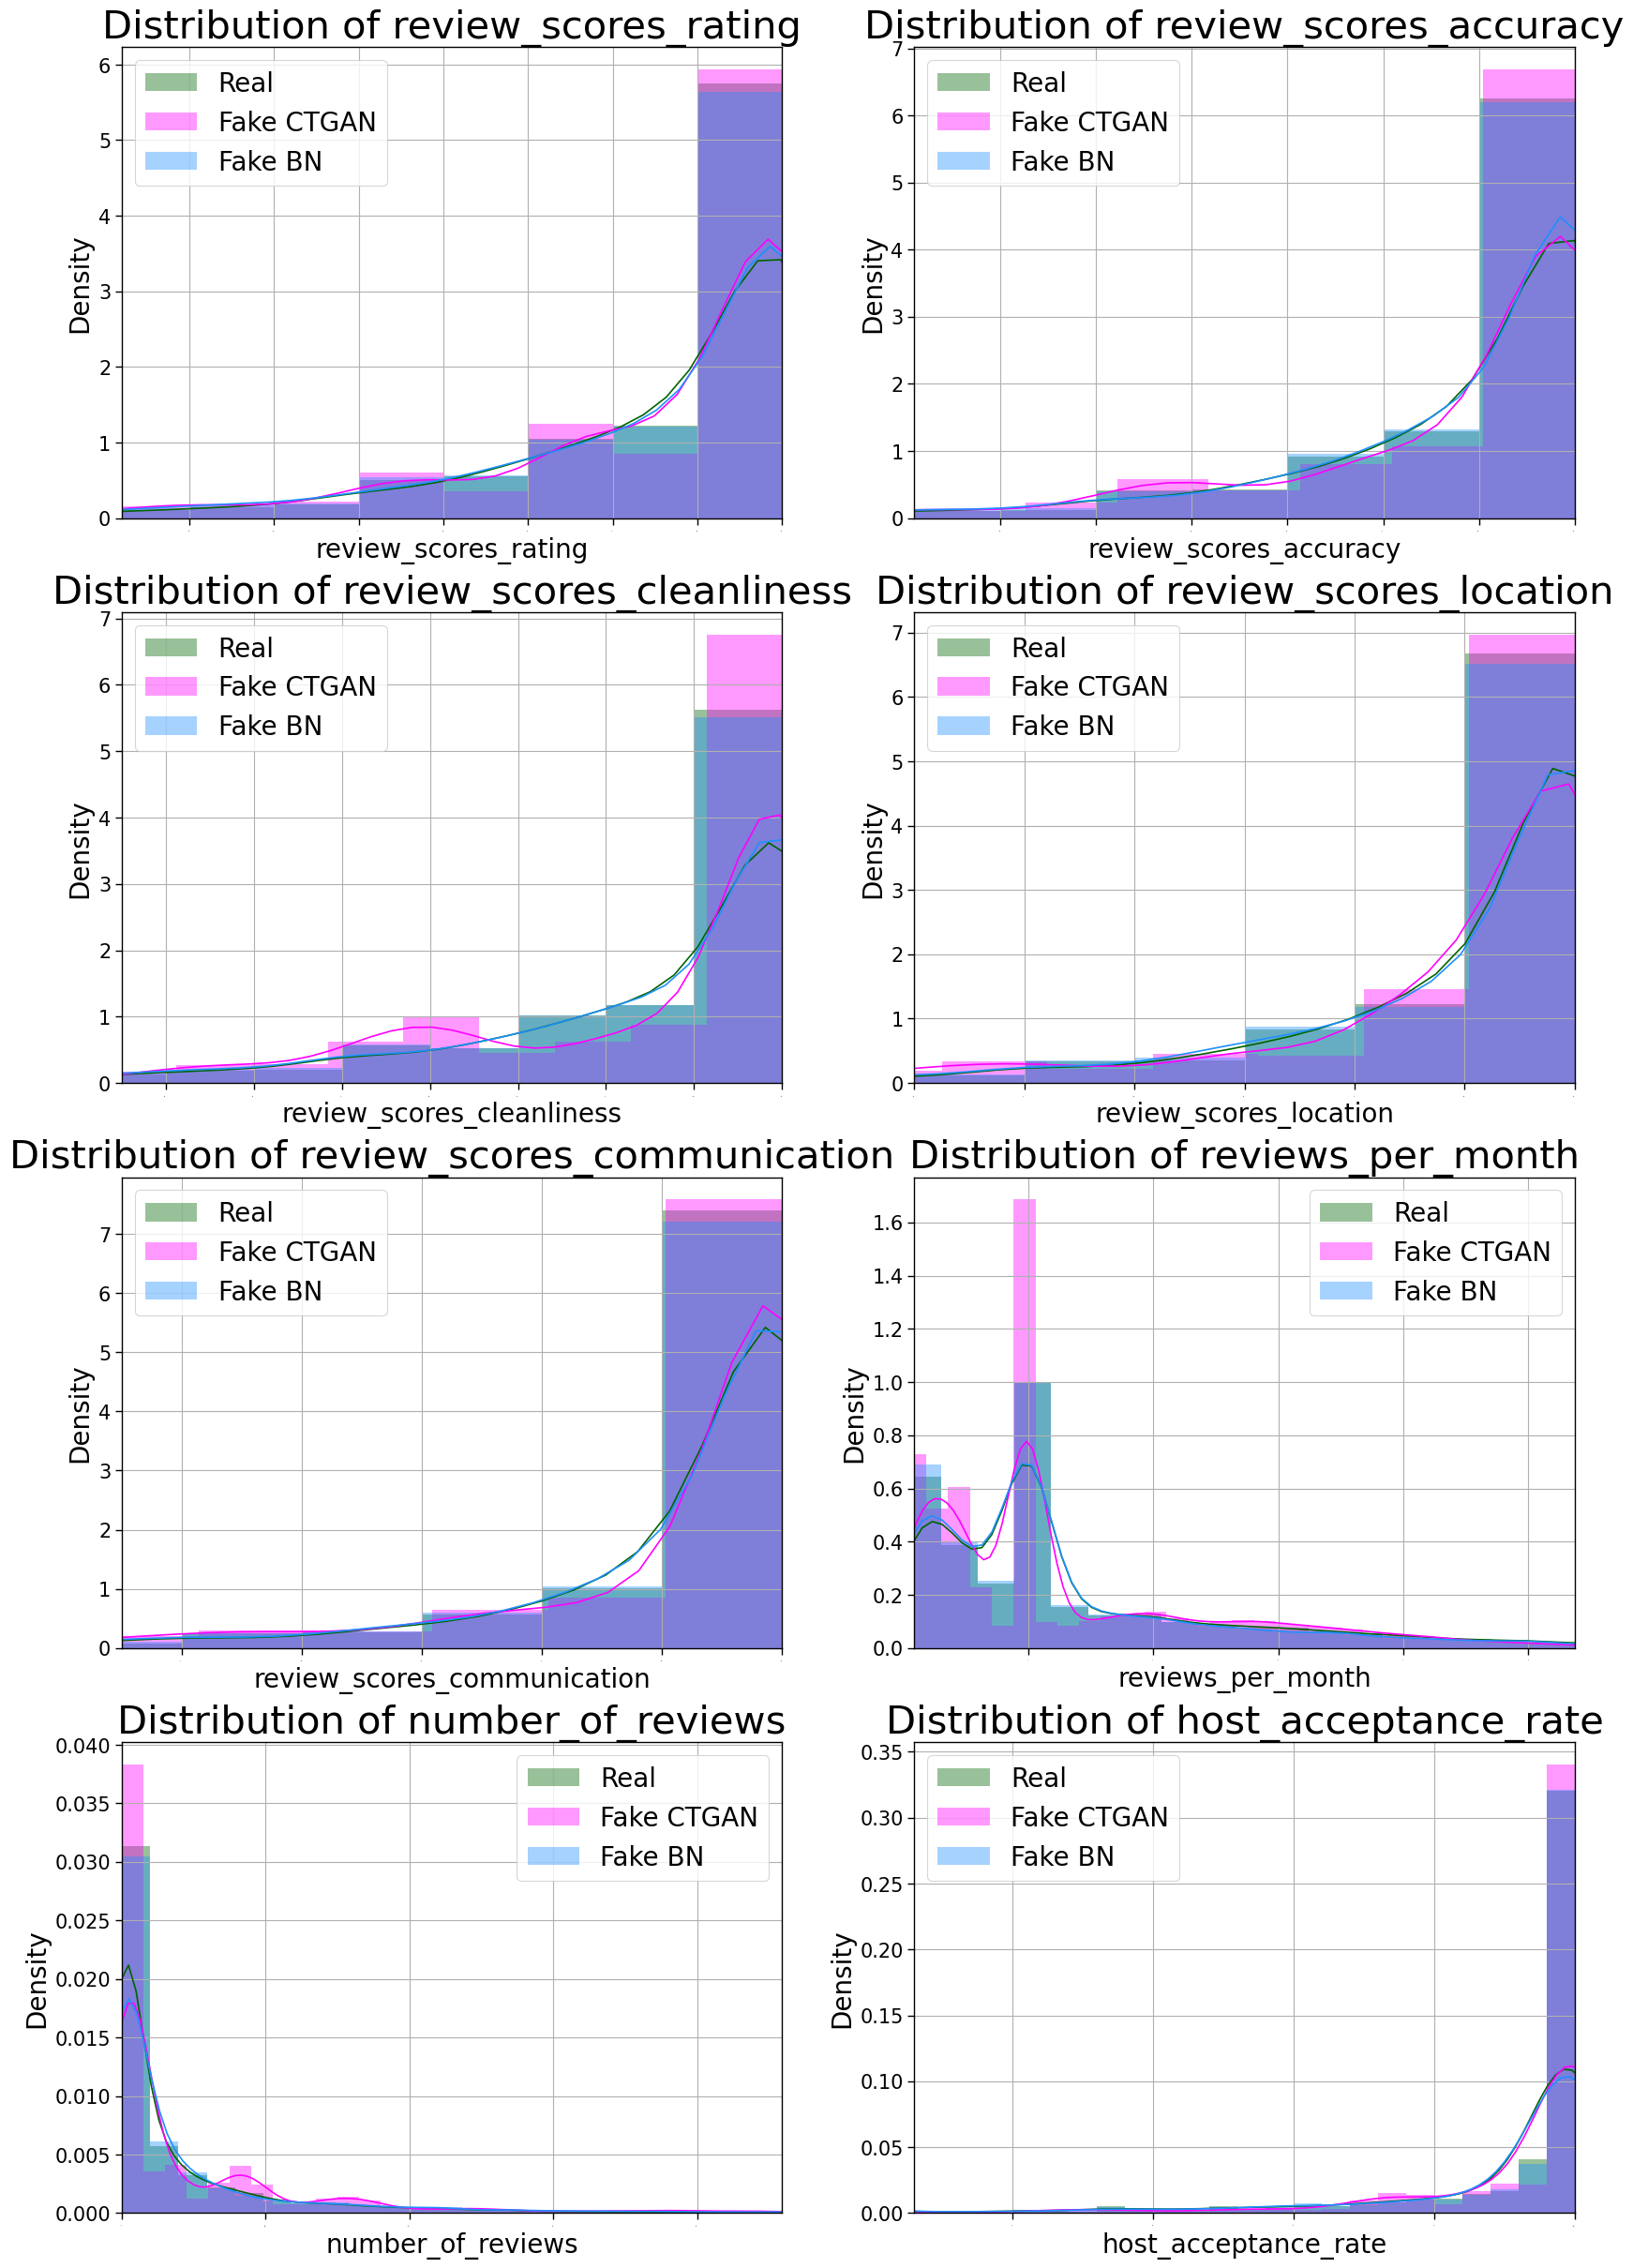

In [219]:
cont_data = real_data.select_dtypes(['float']).columns.drop(['price']).to_list()

cont_data.append('number_of_reviews')
cont_data.append('host_acceptance_rate')

cols = 2

rows = max (1 , len(cont_data) // cols)

sns.set_context("paper", rc={"axes.titlesize":30,"axes.labelsize":20, "legend.fontsize": 20, "xtick.labelsize":1, "ytick.labelsize":15})

fig, ax= plt.subplots(rows, cols, figsize=(20, 30))
axes = ax.flatten()

for i, col in enumerate(cont_data):
    sns.distplot(real_data[col], ax=axes[i], label='Real', color=REAL_COLOR, kde=True)
    sns.distplot(synthetic_data_ctgan[col], ax=axes[i], label='Fake CTGAN', color=CTGAN_COLOR, kde=True)
    sns.distplot(synthetic_data_bamt[col], ax=axes[i], label='Fake BN', color=BAMT_COLOR, kde=True)

    axes[i].grid(True)
    axes[i].legend(loc=0)
    axes[i].set_xlim(np.percentile(synthetic_data_ctgan[col], 5), np.percentile(synthetic_data_ctgan[col], 99))
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Distribution of {col}')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

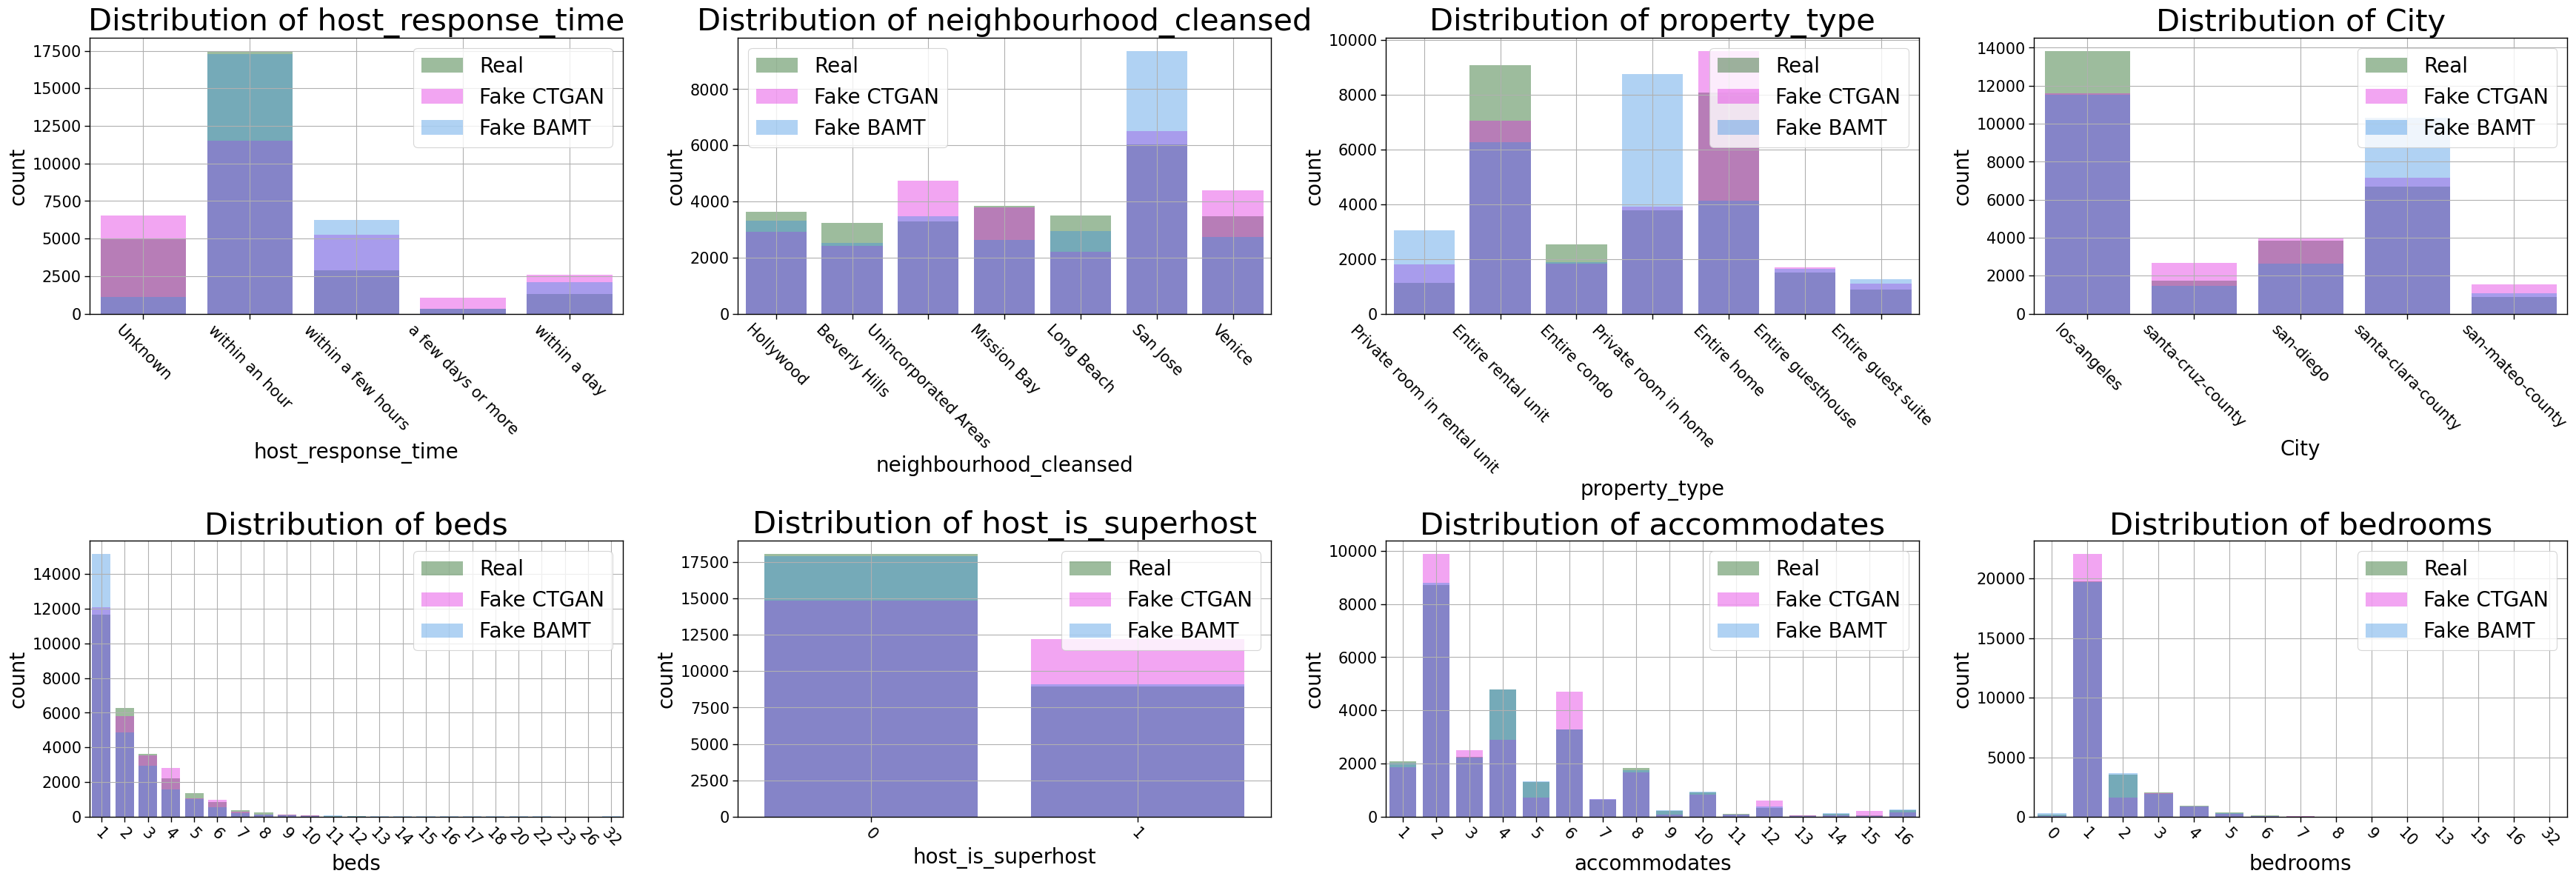

In [220]:
cols = 4
rows = (len(cat_features) + cols - 1) // cols + 1

sns.set_context("paper", rc={"axes.titlesize":30, "axes.labelsize":20, "legend.fontsize":20, "xtick.labelsize":15, "ytick.labelsize":15})

fig, ax = plt.subplots(rows, cols, figsize=(35, 6 * rows))
axes = ax.flatten()

disc_features = cat_features.copy()
disc_features.append('beds')
disc_features.append('host_is_superhost')
disc_features.append('accommodates')
disc_features.append('bedrooms')


for i, col in enumerate(disc_features):
    sns.countplot(x=real_data[col], ax=axes[i], label='Real', color=REAL_COLOR, alpha=0.4)
    sns.countplot(x=synthetic_data_ctgan[col], ax=axes[i], label='Fake CTGAN', color=CTGAN_COLOR, alpha=0.4)
    sns.countplot(x=synthetic_data_bamt[col], ax=axes[i], label='Fake BAMT', color=BAMT_COLOR, alpha=0.4)

    axes[i].grid(True)
    axes[i].legend(loc=0)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=-45)

plt.tight_layout()
plt.show()

# Регрессия. Предсказывание стоимости апартаментов

In [221]:
RFL_pipe = Pipeline([
    ('encoding', ce.OrdinalEncoder(
       encoding_method='ordered', variables=cat_features)),
    ('scaler', StandardScaler()),
    ('RF', RandomForestRegressor())
    ])

In [222]:
for col in cat_features:
    synthetic_data_bamt[col] = synthetic_data_bamt[col].astype('category')
    synthetic_data_ctgan[col] = synthetic_data_ctgan[col].astype('category')

In [223]:
right_pos_df_ctgan = pd.DataFrame()
right_pos_df_bn = pd.DataFrame()

for col in real_data.columns:
    right_pos_df_ctgan[col] = synthetic_data_ctgan[col]
    right_pos_df_bn[col] = synthetic_data_bamt[col]

synthetic_data_ctgan = right_pos_df_ctgan.copy()
synthetic_data_bamt = right_pos_df_bn.copy()

In [224]:
y_pred_test_initial_rfl = fit_predict(RFL_pipe, X_train.copy(), y_train, X_test, y_test, reg=True)
y_pred_test_ctgan_rfl = fit_predict(RFL_pipe, synthetic_data_ctgan.drop(['price'], axis=1), synthetic_data_ctgan['price'], X_test, y_test, reg=True)
y_pred_test_bamt_rfl = fit_predict(RFL_pipe, synthetic_data_bamt.drop(['price'], axis=1), synthetic_data_bamt['price'], X_test, y_test, reg=True)

y_pred_test_initial_lgbm = lgbm_predict(X_train.copy(), y_train, X_test, y_test, cat_features, reg=True)
y_pred_test_ctgan_lgbm = lgbm_predict(synthetic_data_ctgan.drop(['price'], axis=1), synthetic_data_ctgan['price'], X_test, y_test, cat_features, reg=True)
y_pred_test_bamt_lgbm = lgbm_predict(synthetic_data_bamt.drop(['price'], axis=1), synthetic_data_bamt['price'], X_test, y_test, cat_features, reg=True)

y_pred_test_initial_xgb = xgb_predict(X_train.copy(), y_train, X_test, y_test, cat_features)
y_pred_test_ctgan_xgb = xgb_predict(synthetic_data_ctgan.drop(['price'], axis=1), synthetic_data_ctgan['price'], X_test, y_test, cat_features)
y_pred_test_bamt_xgb = xgb_predict(synthetic_data_bamt.drop(['price'], axis=1), synthetic_data_bamt['price'], X_test, y_test, cat_features)

[LightGBM] [Warning] categorical_feature is set=host_response_time,neighbourhood_cleansed,property_type,City, categorical_column=0,1,2,3 will be ignored. Current value: categorical_feature=host_response_time,neighbourhood_cleansed,property_type,City
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 27000, number of used features: 16
[LightGBM] [Info] Start training from score 286.155889
[LightGBM] [Warning] categorical_feature is set=host_response_time,neighbourhood_cleansed,property_type,City, categorical_column=0,1,2,3 will be ignored. Current value: categorical_feature=host_response_time,neighbourhood_cleansed,property_type,City
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0004

# Регрессия. Графики сравнения качества моделей


In [225]:
df_rfreg = pd.DataFrame(data=[mean_absolute_error(y_test,  y_pred_test_initial_rfl), mean_absolute_error(y_test,  y_pred_test_ctgan_rfl), mean_absolute_error(y_test,  y_pred_test_bamt_rfl)],
                     columns = ['Test MAE'],
                     index = ['Initial', 'CTGAN', 'BN'] )
df_rfreg['model']='RF'

df_lgbmreg = pd.DataFrame(data=[mean_absolute_error(y_test,  y_pred_test_initial_lgbm), mean_absolute_error(y_test,  y_pred_test_ctgan_lgbm), mean_absolute_error(y_test,  y_pred_test_bamt_lgbm)],
                   columns = ['Test MAE'],
                      index = ['Initial', 'CTGAN', 'BN'])
df_lgbmreg['model']='Lgbm'


df_xgbreg = pd.DataFrame(data=[mean_absolute_error(y_test,  y_pred_test_initial_xgb), mean_absolute_error(y_test,  y_pred_test_ctgan_xgb), mean_absolute_error(y_test,  y_pred_test_bamt_xgb)],
                   columns = ['Test MAE'],
                      index = ['Initial', 'CTGAN', 'BN'])
df_xgbreg['model']='XGB'

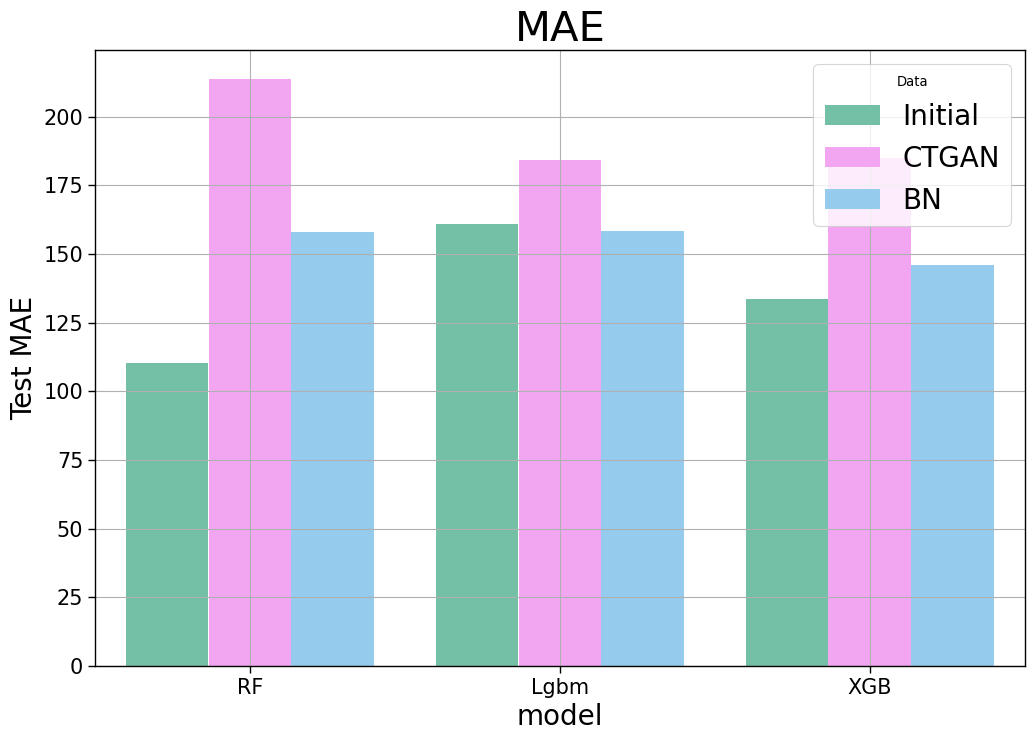

In [226]:
df = pd.concat([df_rfreg, df_lgbmreg, df_xgbreg])
df.index.rename('Data', inplace=True)
df.reset_index(inplace=True)

pastel_colors = ['#66CDAA', '#FF99FF', '#87CEFA']

fig = plt.figure(figsize=(12, 8))
sns.barplot(x='model', y='Test MAE', hue='Data', data=df, palette=pastel_colors)
plt.title('MAE')
plt.grid()
plt.show()